Processing pair: subject_01_subjec.csv and subject_02_subjec.csv


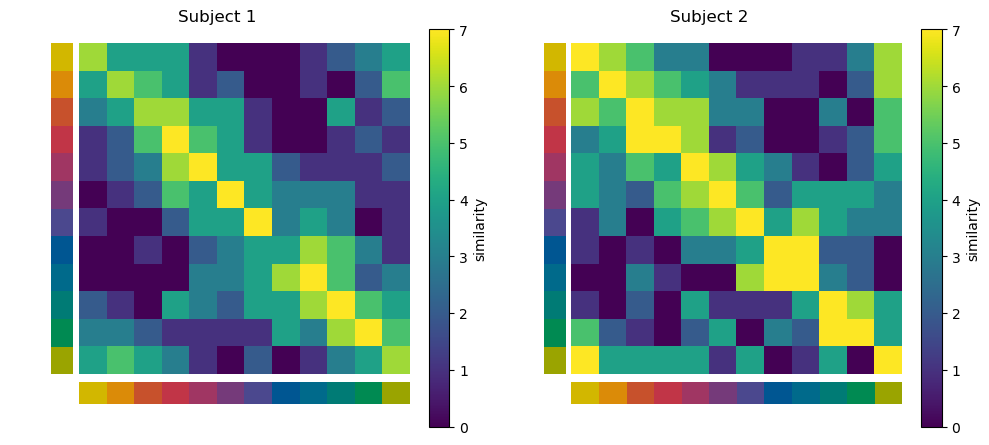

RSA correlation coefficient between subject_01_subjec.csv and subject_02_subjec.csv: 0.7350242926380575


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


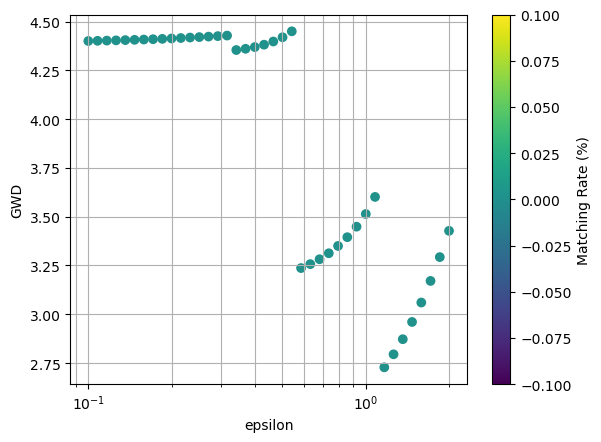

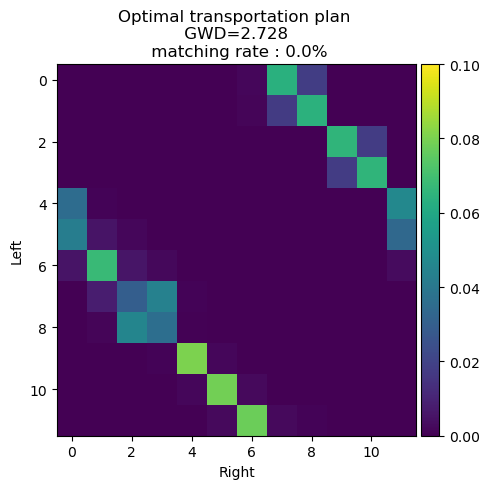

Minimum GWD for subject_01_subjec.csv and subject_02_subjec.csv: 2.728100779236086 at epsilon 1.1681854462543095 with matching rate 0.0
Processing pair: subject_01_subjec.csv and subject_03_subjec.csv


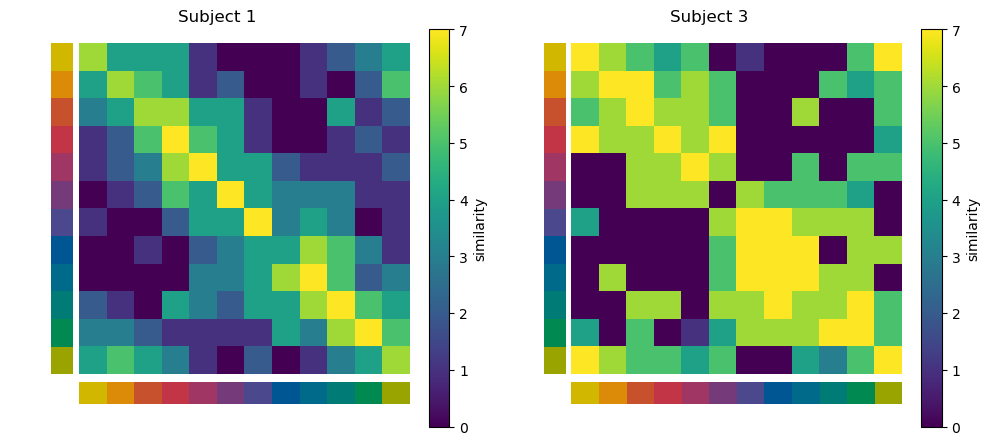

RSA correlation coefficient between subject_01_subjec.csv and subject_03_subjec.csv: 0.5248150319329484


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


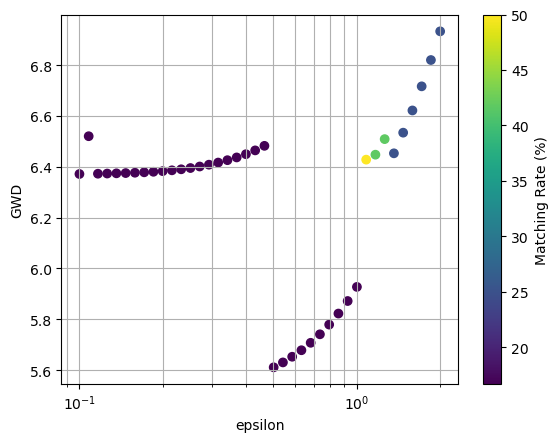

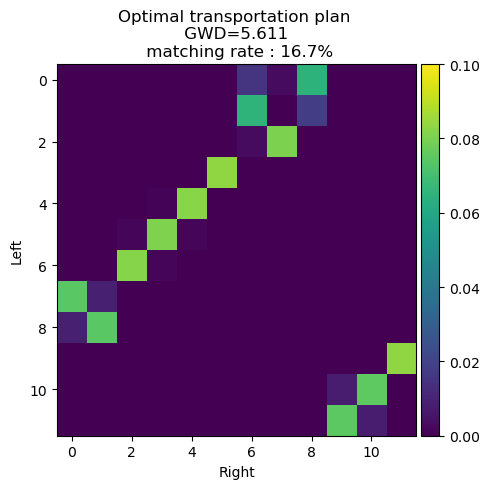

Minimum GWD for subject_01_subjec.csv and subject_03_subjec.csv: 5.6108097896934686 at epsilon 0.5018276804993071 with matching rate 16.666666666666664
Processing pair: subject_01_subjec.csv and subject_04_subjec.csv


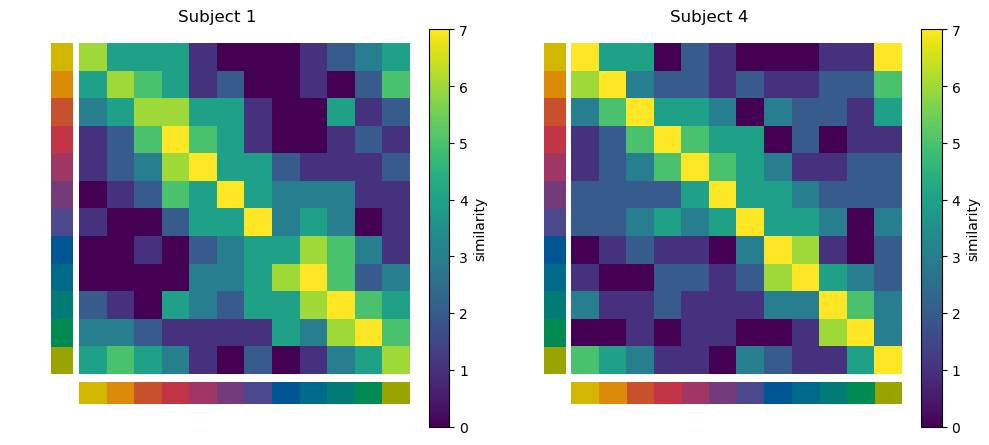

RSA correlation coefficient between subject_01_subjec.csv and subject_04_subjec.csv: 0.6375489543771462


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


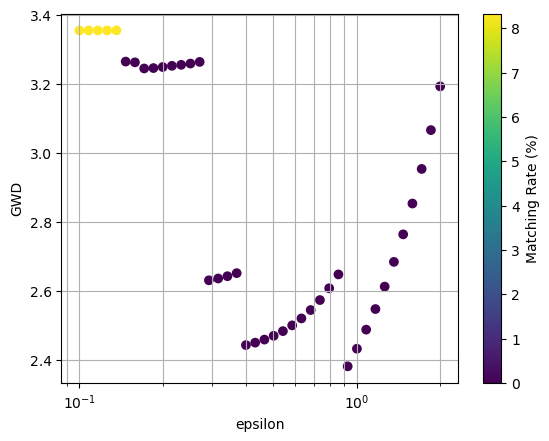

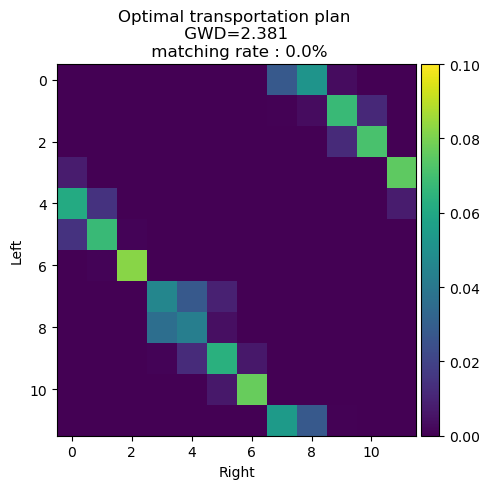

Minimum GWD for subject_01_subjec.csv and subject_04_subjec.csv: 2.3810131271252075 at epsilon 0.9277534133867849 with matching rate 0.0
Processing pair: subject_01_subjec.csv and subject_05_subjec.csv


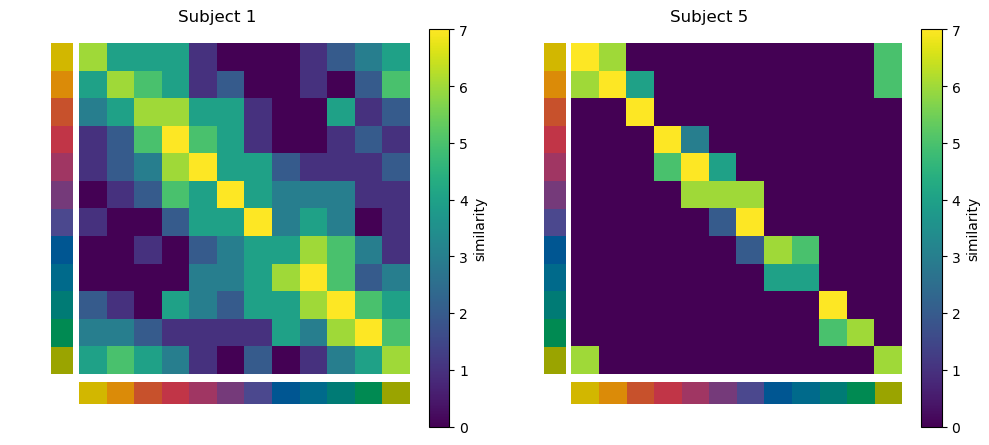

RSA correlation coefficient between subject_01_subjec.csv and subject_05_subjec.csv: 0.44362687452297156


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


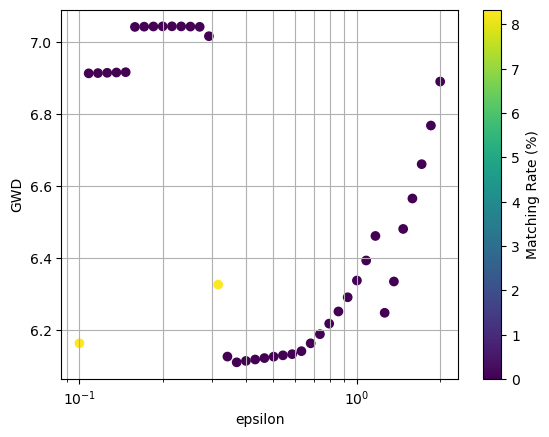

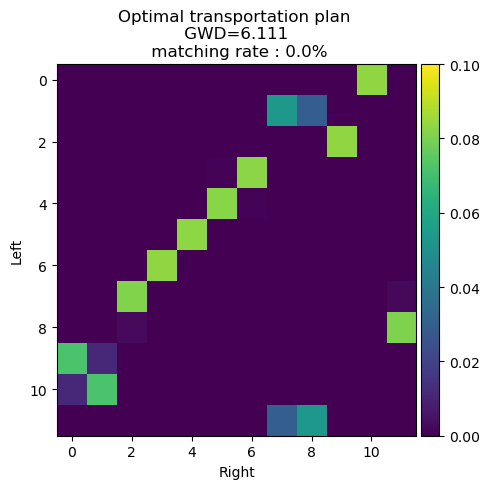

Minimum GWD for subject_01_subjec.csv and subject_05_subjec.csv: 6.11132277518358 at epsilon 0.3690758589290662 with matching rate 0.0
Processing pair: subject_01_subjec.csv and subject_06_subjec.csv


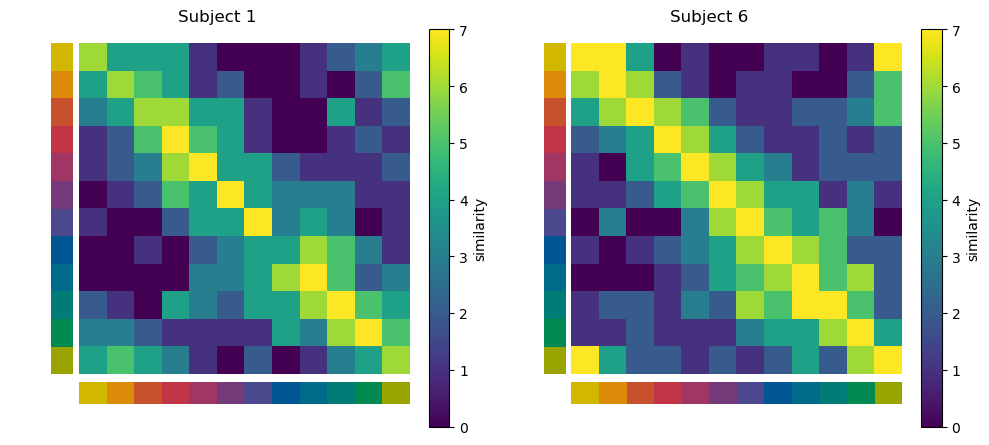

RSA correlation coefficient between subject_01_subjec.csv and subject_06_subjec.csv: 0.7086076482802064


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


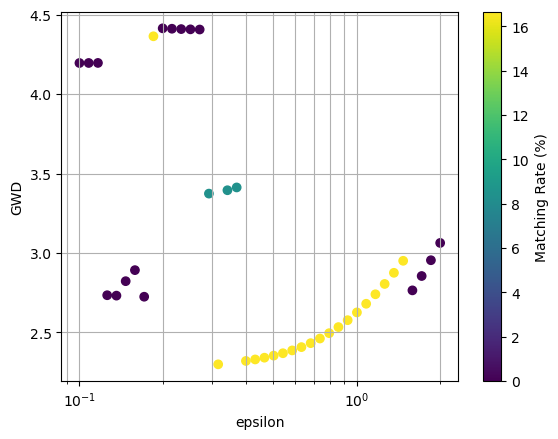

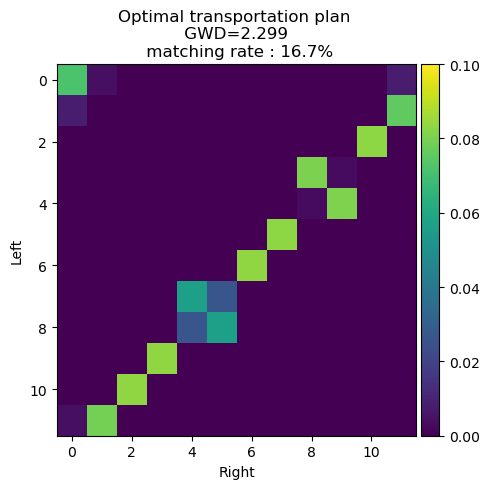

Minimum GWD for subject_01_subjec.csv and subject_06_subjec.csv: 2.2990054022705007 at epsilon 0.31651635239541004 with matching rate 16.666666666666664
Processing pair: subject_01_subjec.csv and subject_07_subjec.csv


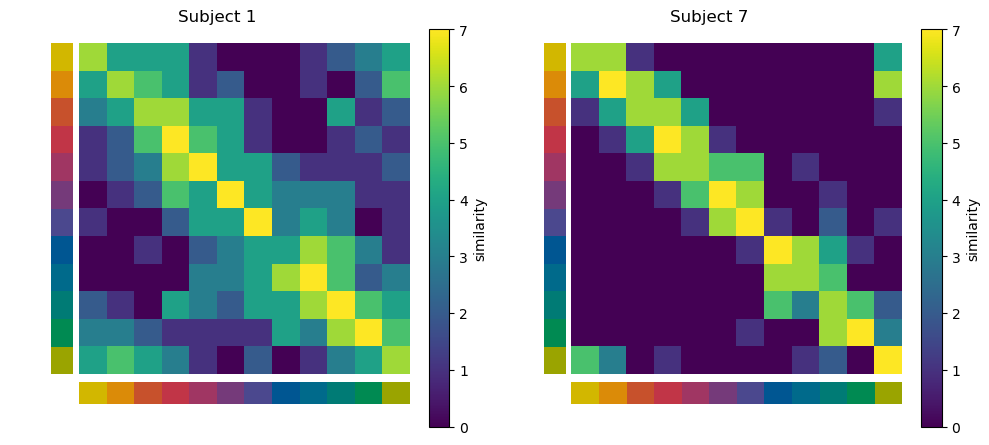

RSA correlation coefficient between subject_01_subjec.csv and subject_07_subjec.csv: 0.7639531895409007


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


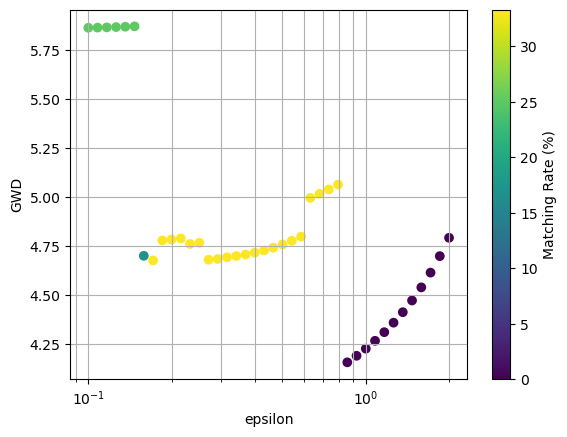

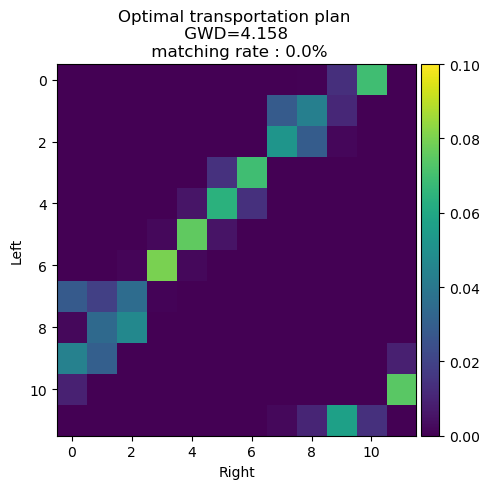

Minimum GWD for subject_01_subjec.csv and subject_07_subjec.csv: 4.157877792805676 at epsilon 0.8591575628824625 with matching rate 0.0
Processing pair: subject_01_subjec.csv and subject_08_subjec.csv


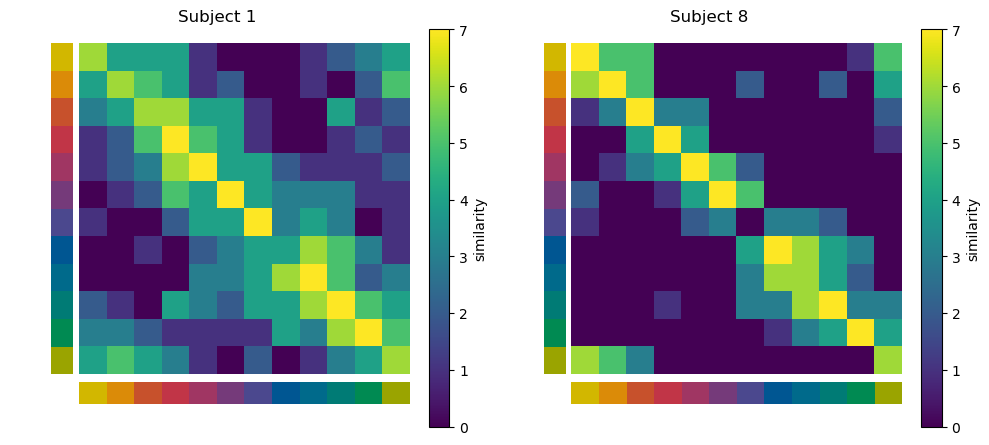

RSA correlation coefficient between subject_01_subjec.csv and subject_08_subjec.csv: 0.7084190180021657


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


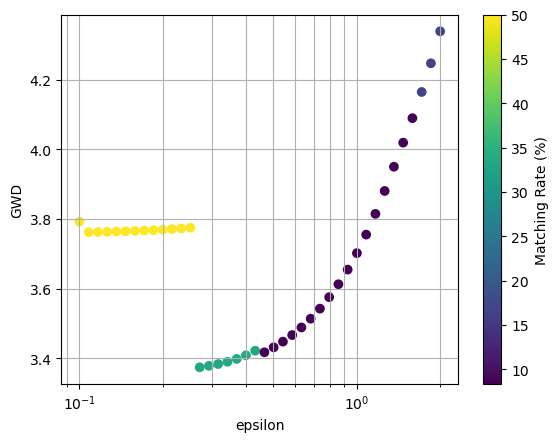

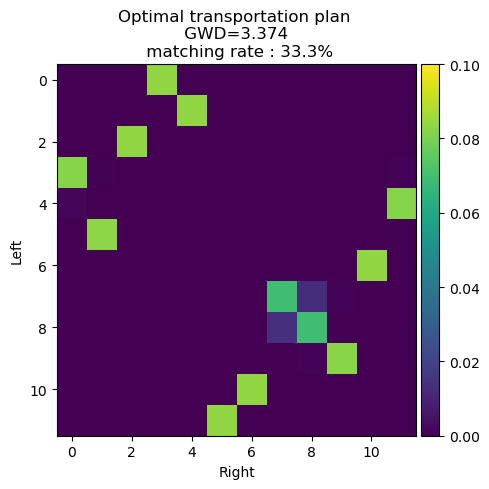

Minimum GWD for subject_01_subjec.csv and subject_08_subjec.csv: 3.373958530154182 at epsilon 0.2714417616594907 with matching rate 33.33333333333333
Processing pair: subject_01_subjec.csv and subject_09_subjec.csv


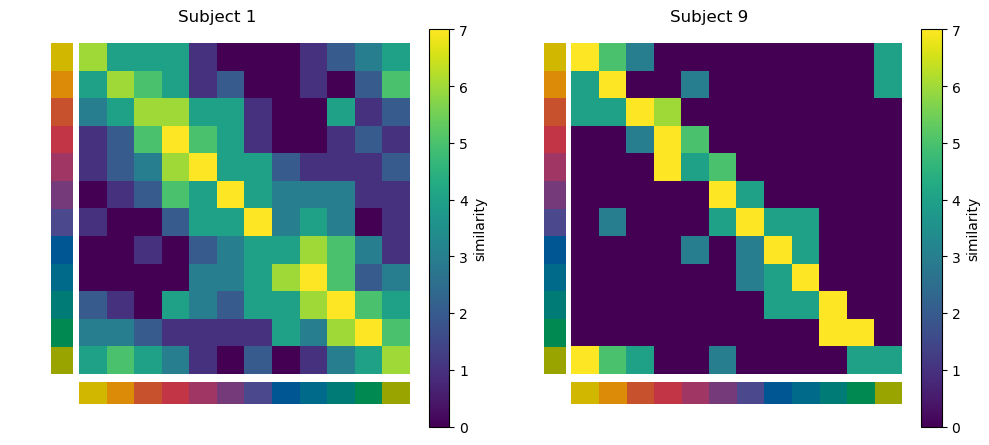

RSA correlation coefficient between subject_01_subjec.csv and subject_09_subjec.csv: 0.49444647264123276


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


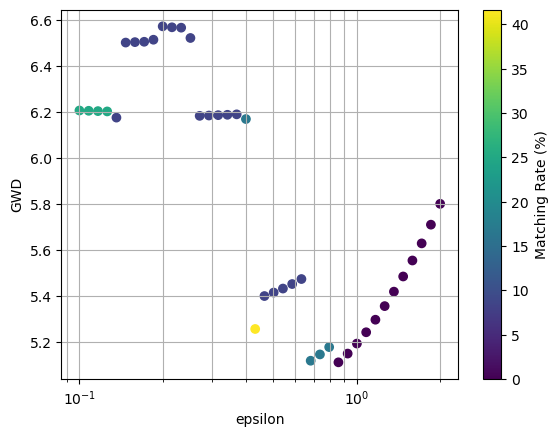

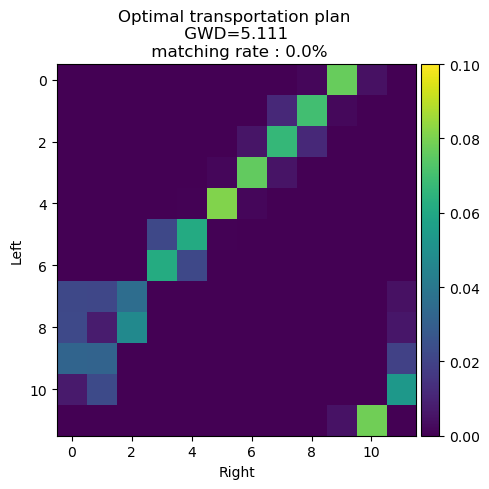

Minimum GWD for subject_01_subjec.csv and subject_09_subjec.csv: 5.1107946296768265 at epsilon 0.8591575628824625 with matching rate 0.0
Processing pair: subject_01_subjec.csv and subject_10_subjec.csv


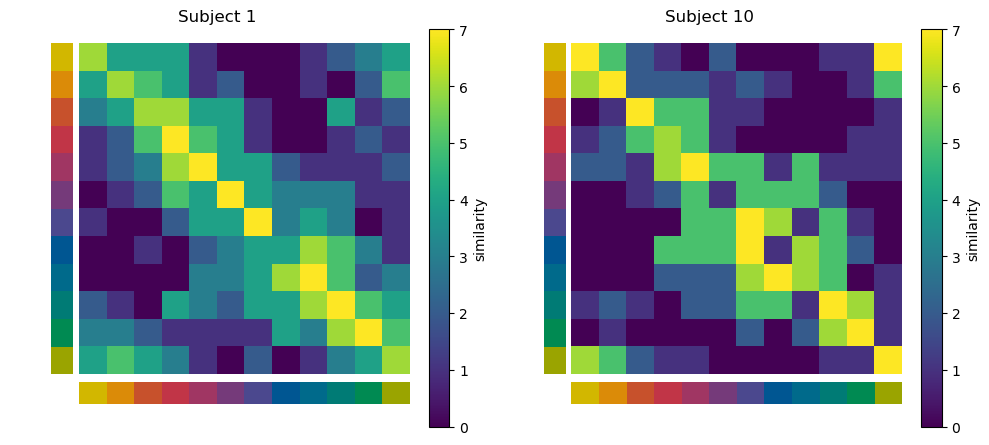

RSA correlation coefficient between subject_01_subjec.csv and subject_10_subjec.csv: 0.6569881556888252


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


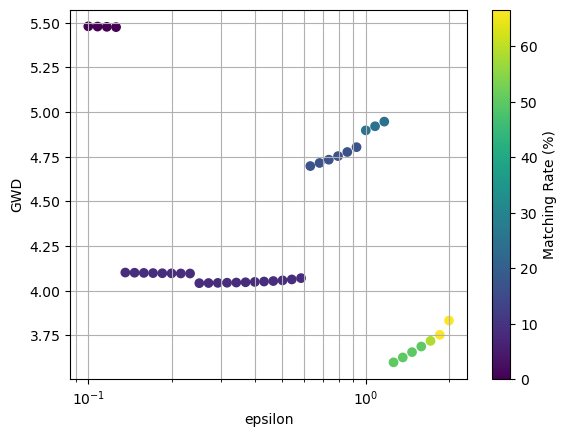

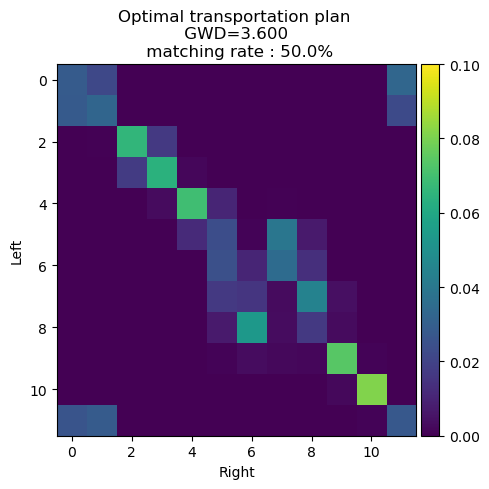

Minimum GWD for subject_01_subjec.csv and subject_10_subjec.csv: 3.599658583363322 at epsilon 1.2614543385908228 with matching rate 50.0
Processing pair: subject_01_subjec.csv and subject_11_subjec.csv


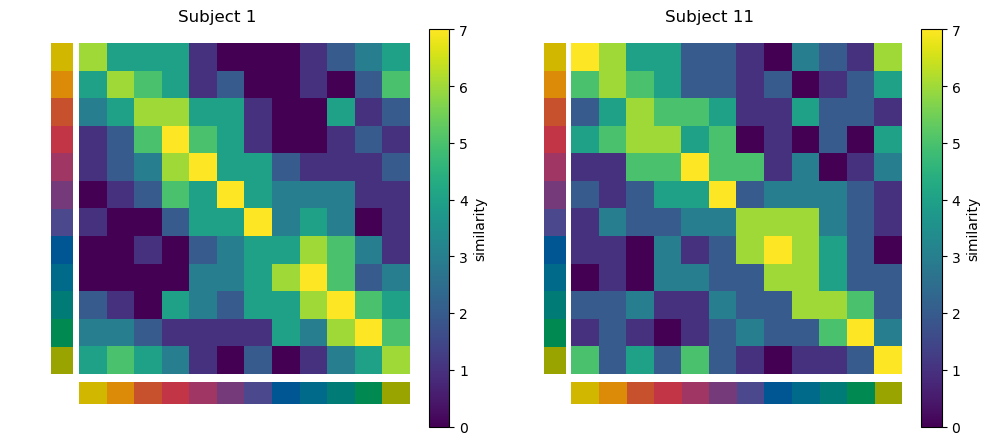

RSA correlation coefficient between subject_01_subjec.csv and subject_11_subjec.csv: 0.7223446907889285


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


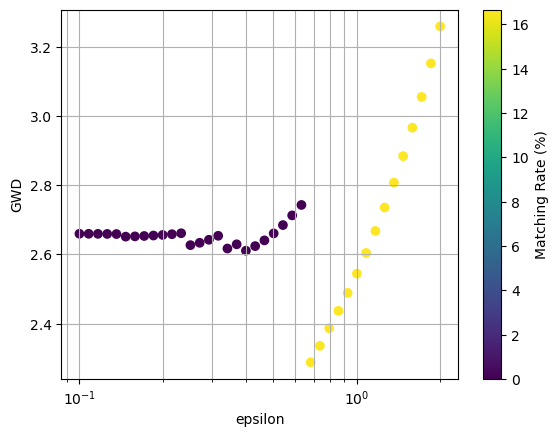

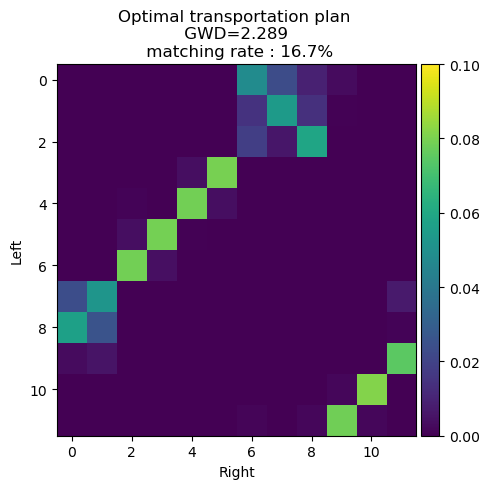

Minimum GWD for subject_01_subjec.csv and subject_11_subjec.csv: 2.288516100821549 at epsilon 0.6823286184201898 with matching rate 16.666666666666664
Processing pair: subject_01_subjec.csv and subject_12_subjec.csv


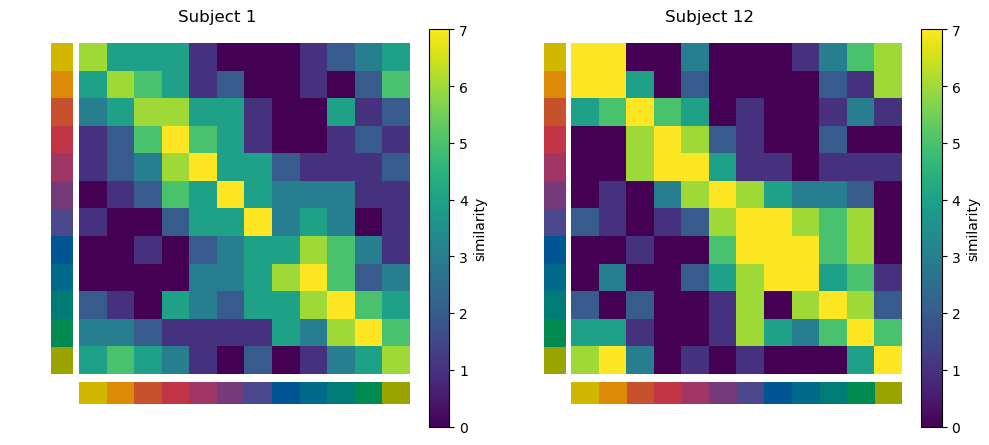

RSA correlation coefficient between subject_01_subjec.csv and subject_12_subjec.csv: 0.6160442078973202


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


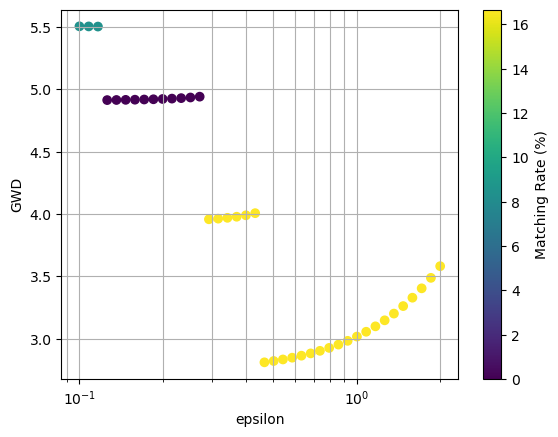

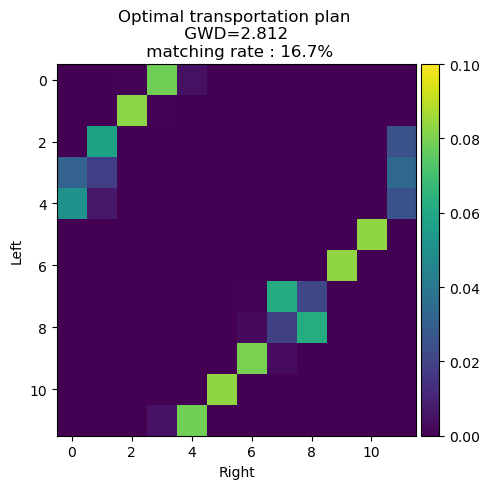

Minimum GWD for subject_01_subjec.csv and subject_12_subjec.csv: 2.811723084447745 at epsilon 0.4647237517465167 with matching rate 16.666666666666664
Processing pair: subject_01_subjec.csv and subject_13_subjec.csv


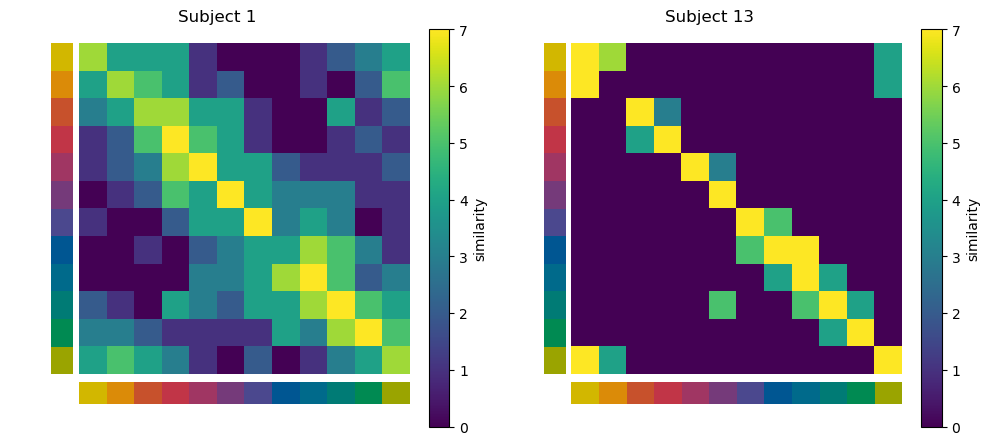

RSA correlation coefficient between subject_01_subjec.csv and subject_13_subjec.csv: 0.48526301652315834


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


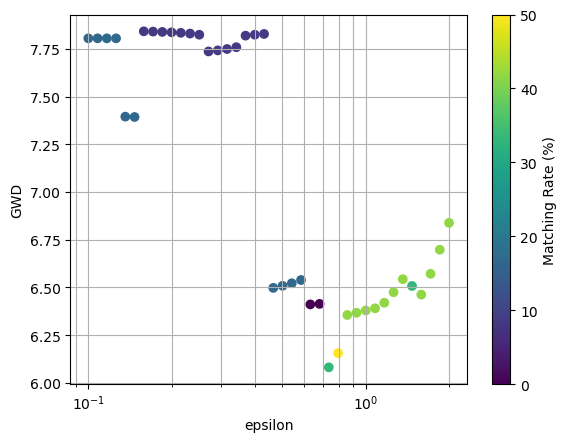

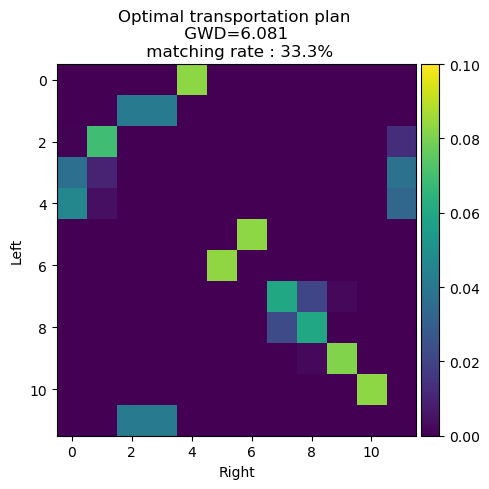

Minimum GWD for subject_01_subjec.csv and subject_13_subjec.csv: 6.08077846456666 at epsilon 0.7368062997280774 with matching rate 33.33333333333333
Processing pair: subject_01_subjec.csv and subject_14_subjec.csv


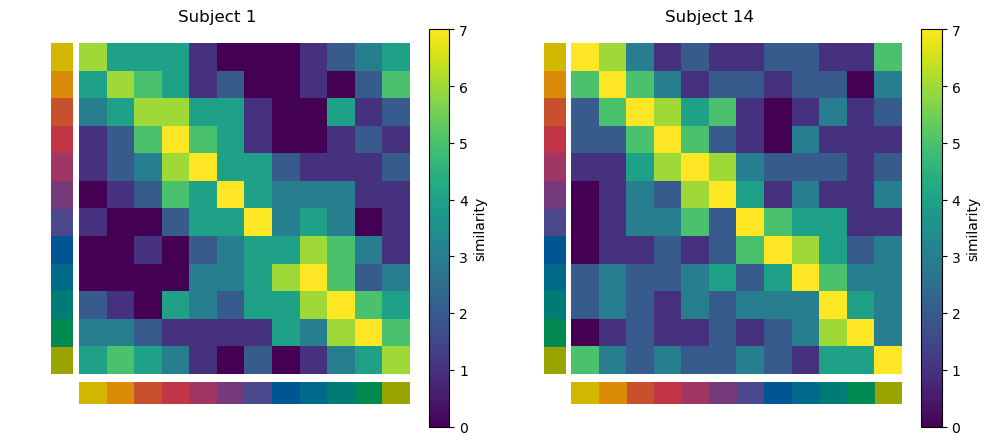

RSA correlation coefficient between subject_01_subjec.csv and subject_14_subjec.csv: 0.7355350503746451


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


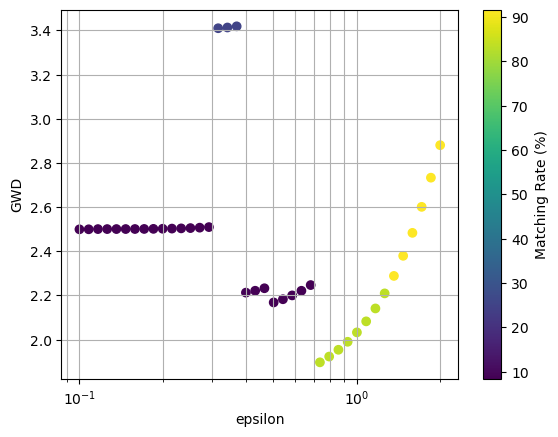

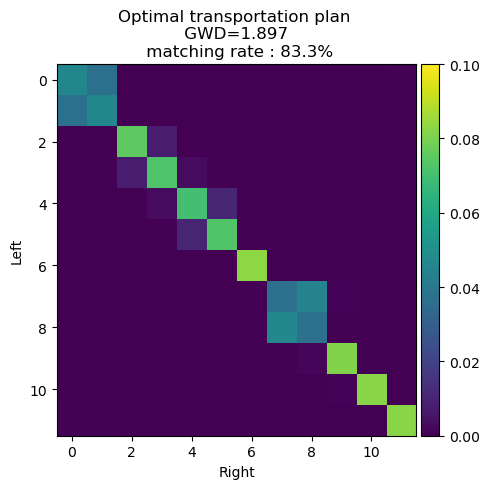

Minimum GWD for subject_01_subjec.csv and subject_14_subjec.csv: 1.8968136413490888 at epsilon 0.7368062997280774 with matching rate 83.33333333333334
Processing pair: subject_01_subjec.csv and subject_15_subjec.csv


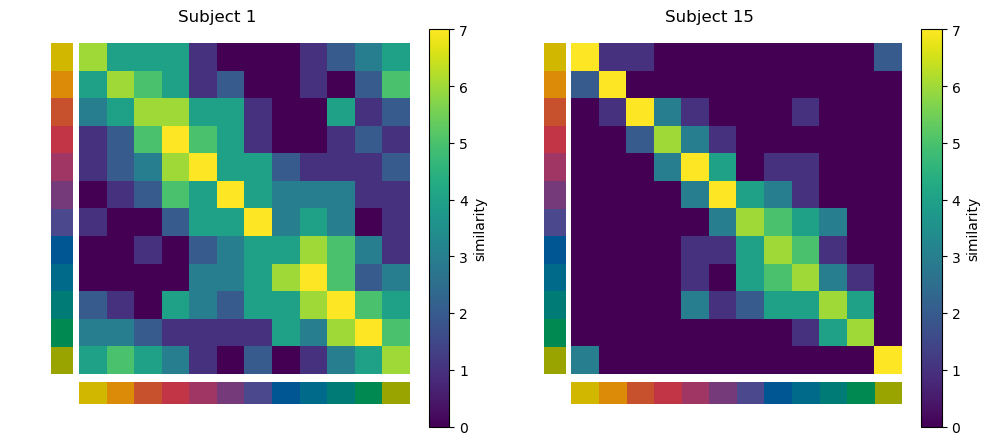

RSA correlation coefficient between subject_01_subjec.csv and subject_15_subjec.csv: 0.5362428627035075


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


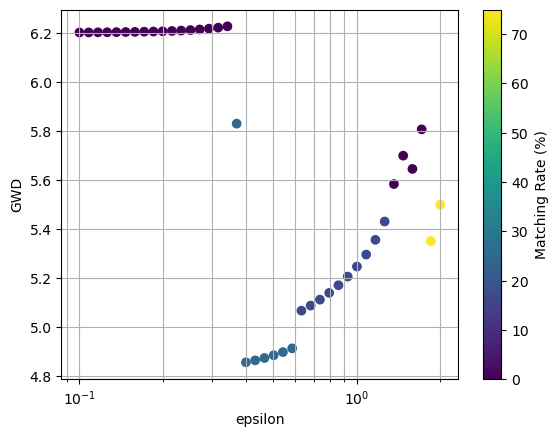

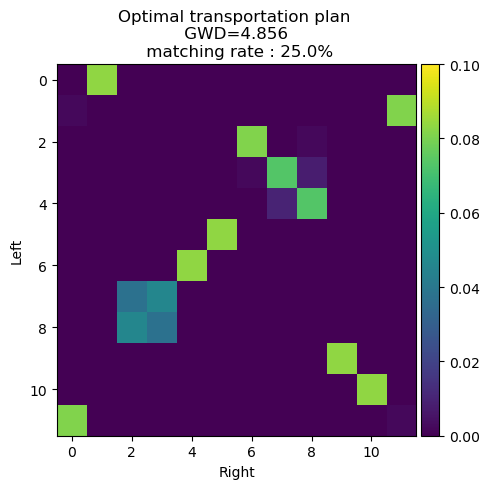

Minimum GWD for subject_01_subjec.csv and subject_15_subjec.csv: 4.855920474027019 at epsilon 0.39854318080063783 with matching rate 25.0
Processing pair: subject_01_subjec.csv and subject_16_subjec.csv


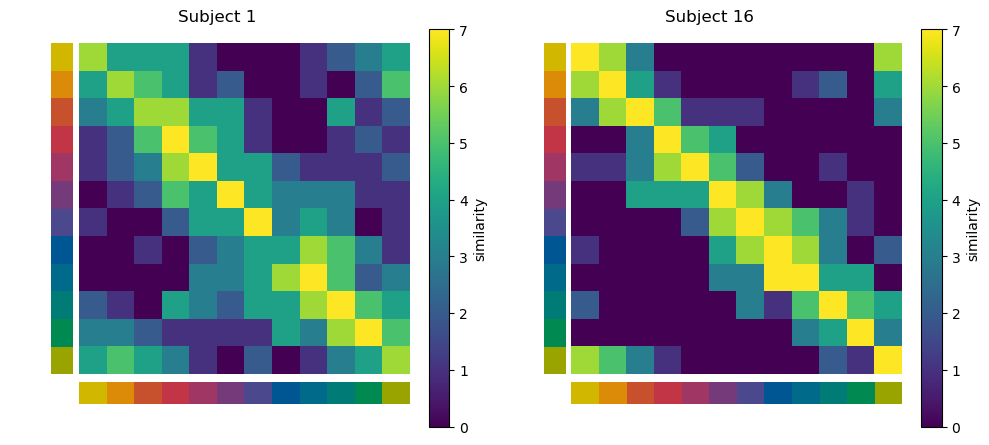

RSA correlation coefficient between subject_01_subjec.csv and subject_16_subjec.csv: 0.6966837158096875


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


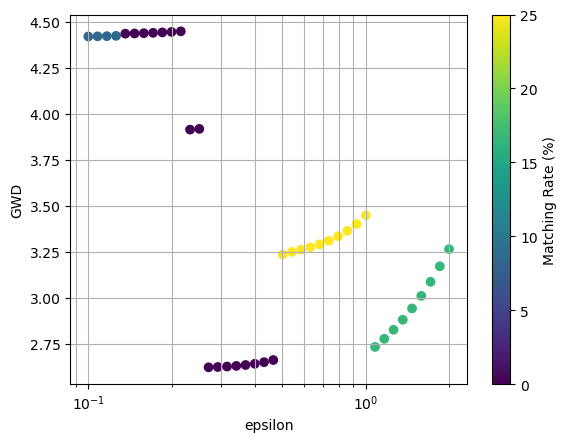

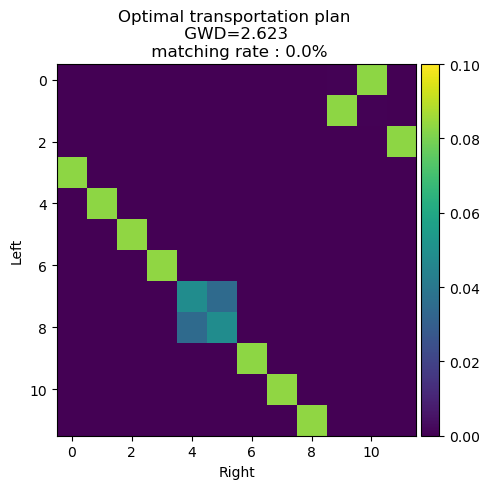

Minimum GWD for subject_01_subjec.csv and subject_16_subjec.csv: 2.6231421857597077 at epsilon 0.2714417616594907 with matching rate 0.0
Processing pair: subject_01_subjec.csv and subject_17_subjec.csv


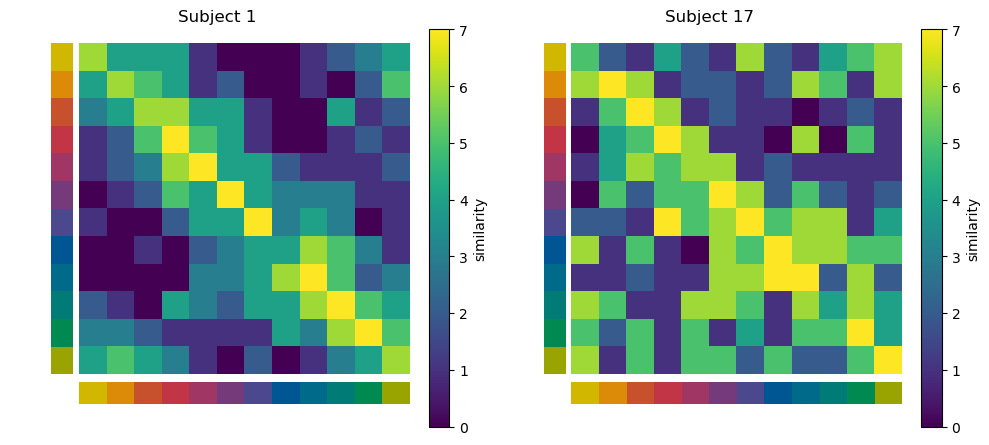

RSA correlation coefficient between subject_01_subjec.csv and subject_17_subjec.csv: 0.43571872483071034


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


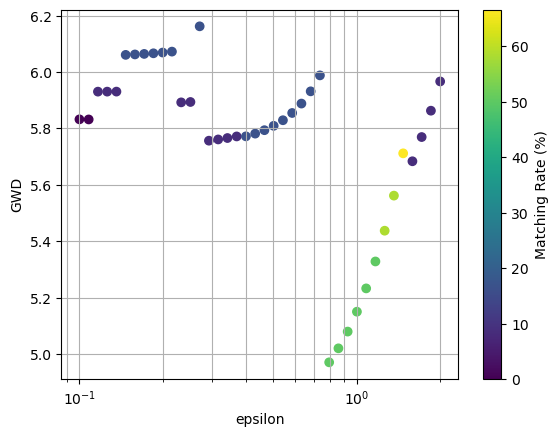

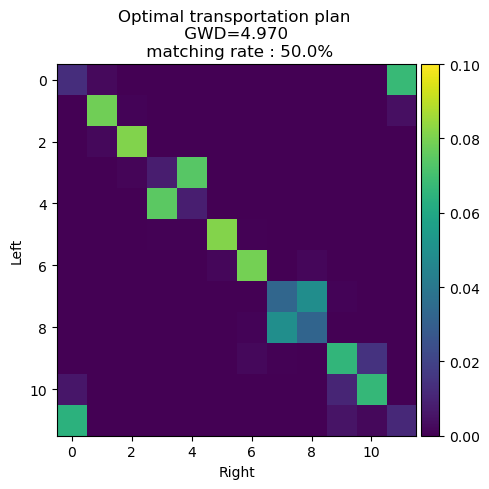

Minimum GWD for subject_01_subjec.csv and subject_17_subjec.csv: 4.970209009844088 at epsilon 0.795633524174805 with matching rate 50.0
Processing pair: subject_01_subjec.csv and subject_18_subjec.csv


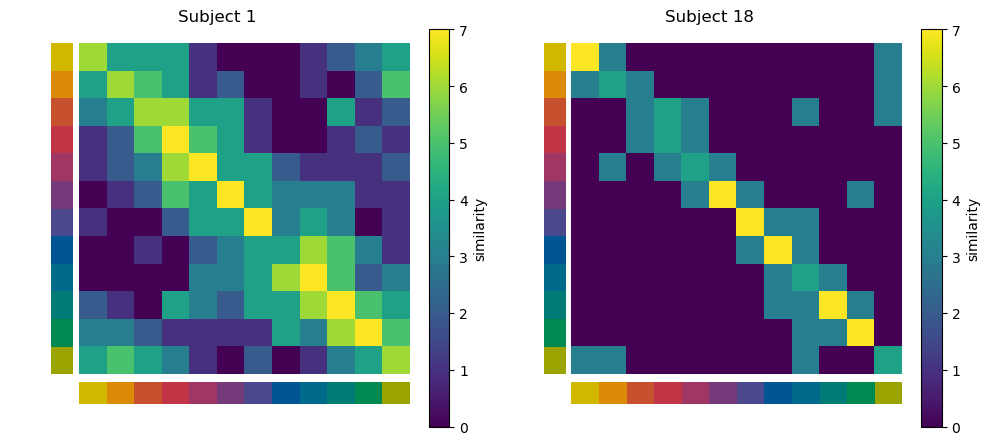

RSA correlation coefficient between subject_01_subjec.csv and subject_18_subjec.csv: 0.51946229290854


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


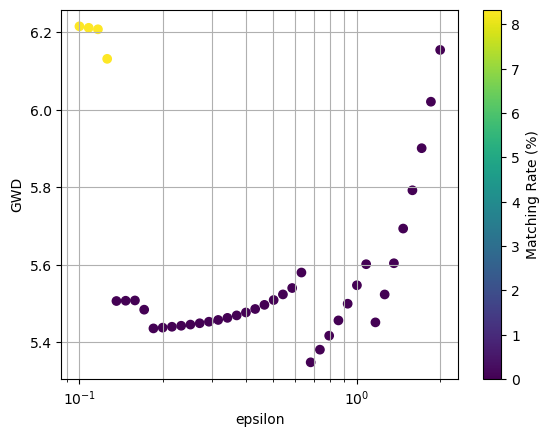

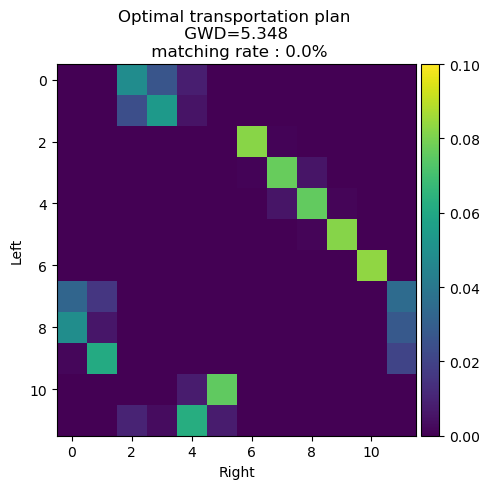

Minimum GWD for subject_01_subjec.csv and subject_18_subjec.csv: 5.348318637842768 at epsilon 0.6823286184201898 with matching rate 0.0
Processing pair: subject_01_subjec.csv and subject_19_subjec.csv


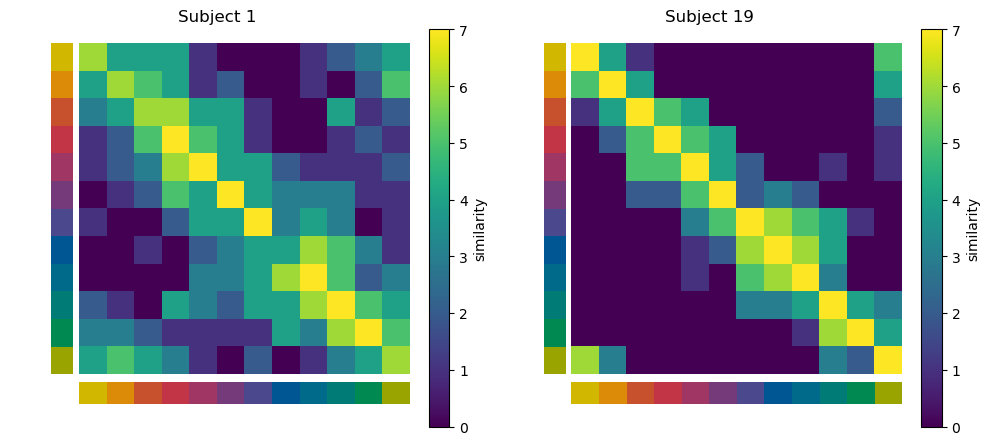

RSA correlation coefficient between subject_01_subjec.csv and subject_19_subjec.csv: 0.7450035002897554


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


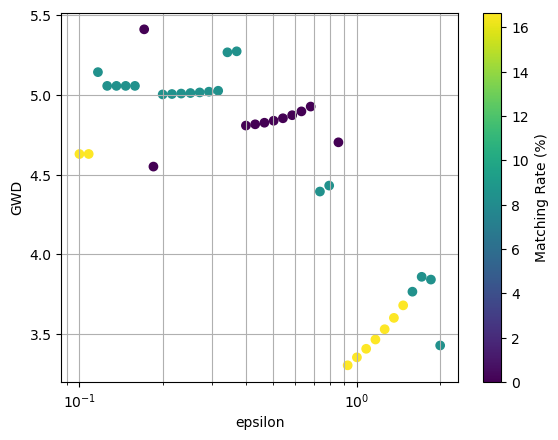

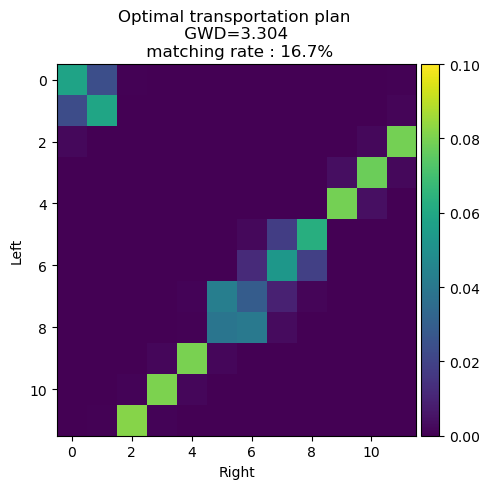

Minimum GWD for subject_01_subjec.csv and subject_19_subjec.csv: 3.304113641408082 at epsilon 0.9277534133867849 with matching rate 16.666666666666664
Processing pair: subject_02_subjec.csv and subject_03_subjec.csv


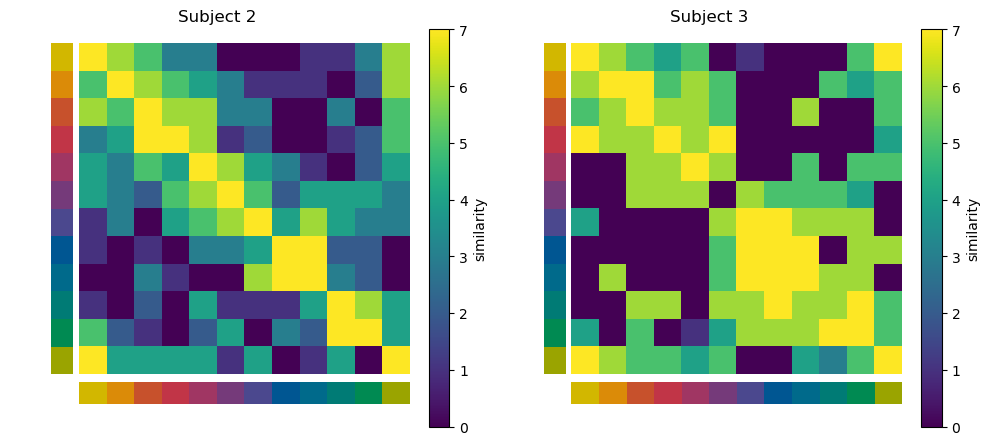

RSA correlation coefficient between subject_02_subjec.csv and subject_03_subjec.csv: 0.6124736726717039


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


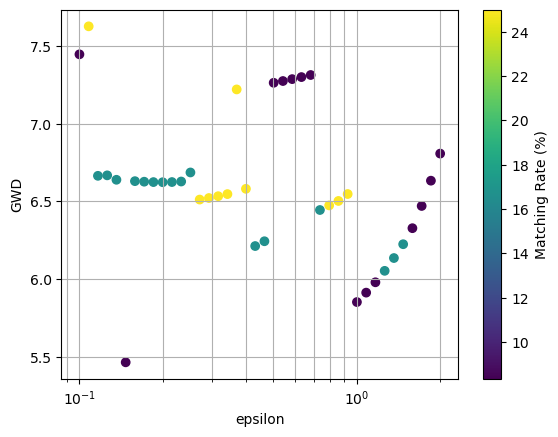

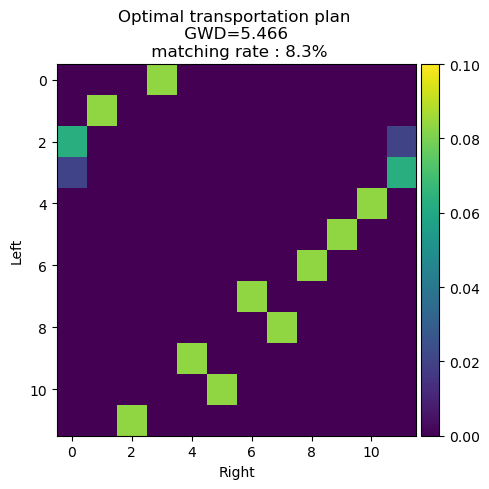

Minimum GWD for subject_02_subjec.csv and subject_03_subjec.csv: 5.4661592231152225 at epsilon 0.14682456316378803 with matching rate 8.333333333333332
Processing pair: subject_02_subjec.csv and subject_04_subjec.csv


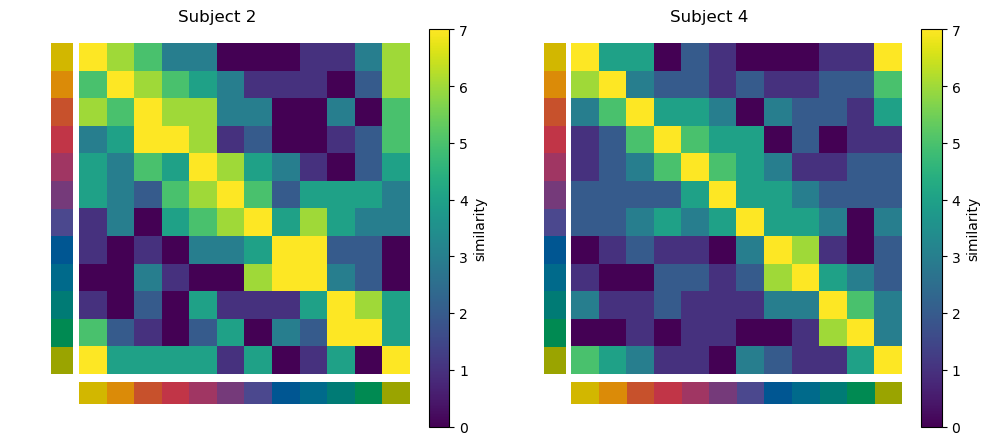

RSA correlation coefficient between subject_02_subjec.csv and subject_04_subjec.csv: 0.6692173162209794


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


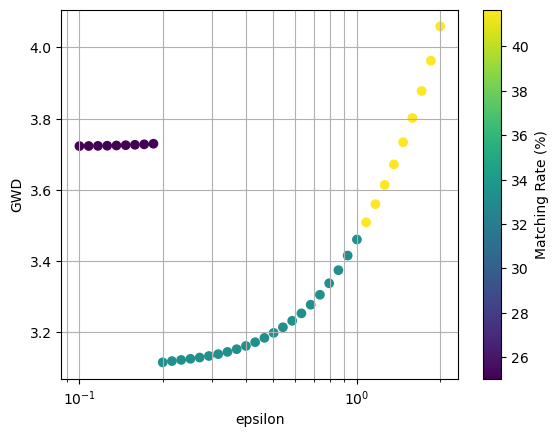

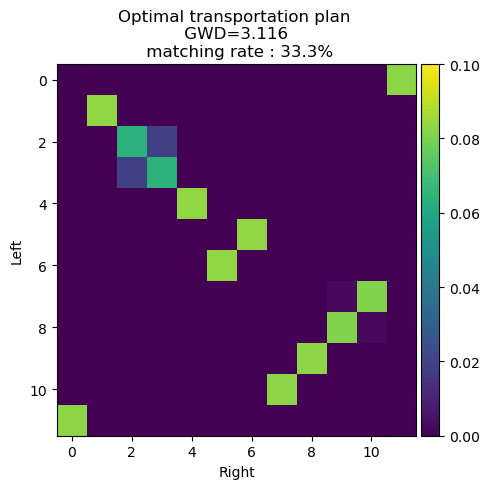

Minimum GWD for subject_02_subjec.csv and subject_04_subjec.csv: 3.1155966165638214 at epsilon 0.19963546298206583 with matching rate 33.33333333333333
Processing pair: subject_02_subjec.csv and subject_05_subjec.csv


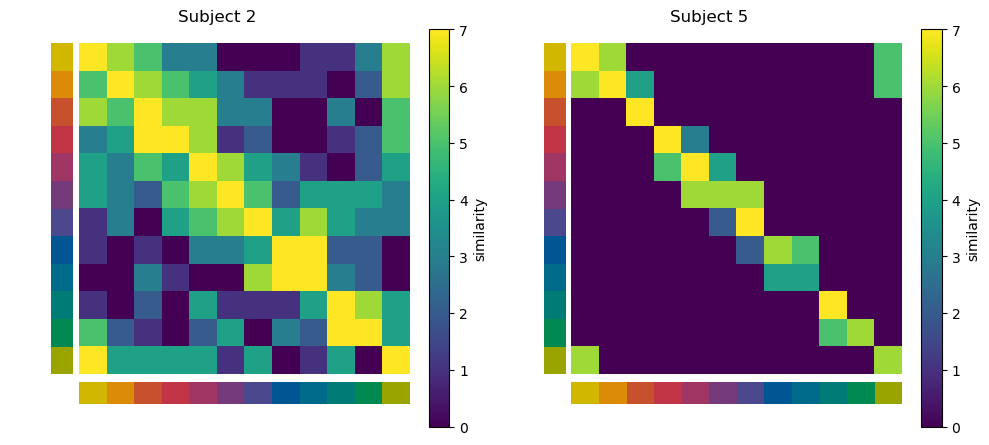

RSA correlation coefficient between subject_02_subjec.csv and subject_05_subjec.csv: 0.5366636574038717


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


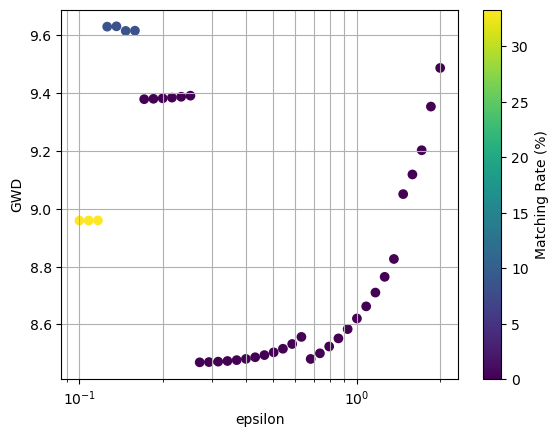

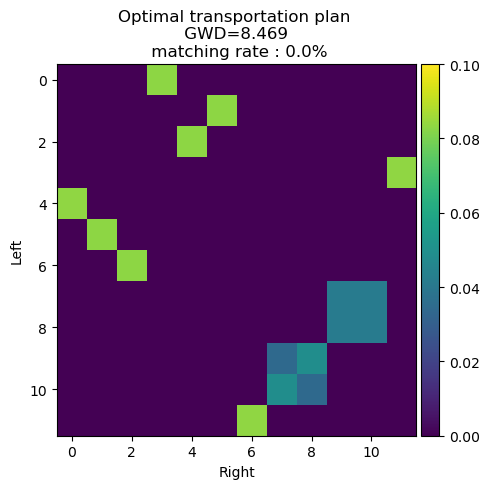

Minimum GWD for subject_02_subjec.csv and subject_05_subjec.csv: 8.469315438844848 at epsilon 0.2714417616594907 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_06_subjec.csv


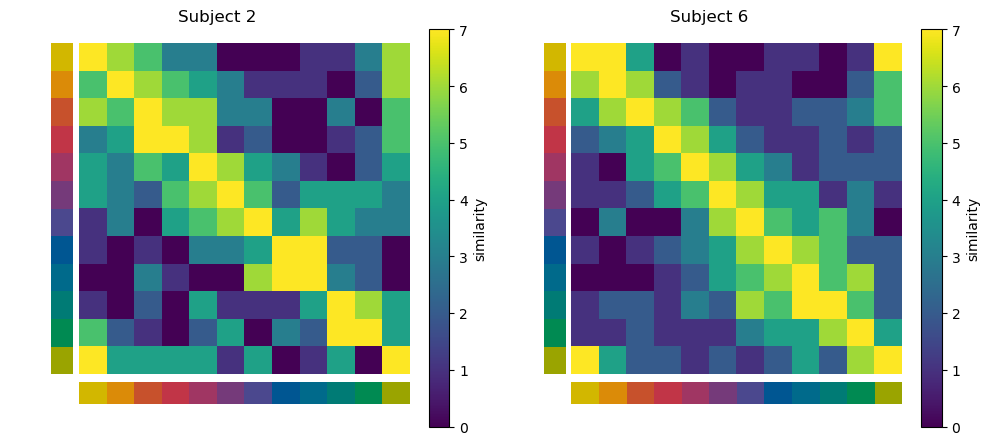

RSA correlation coefficient between subject_02_subjec.csv and subject_06_subjec.csv: 0.6837246362091834


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


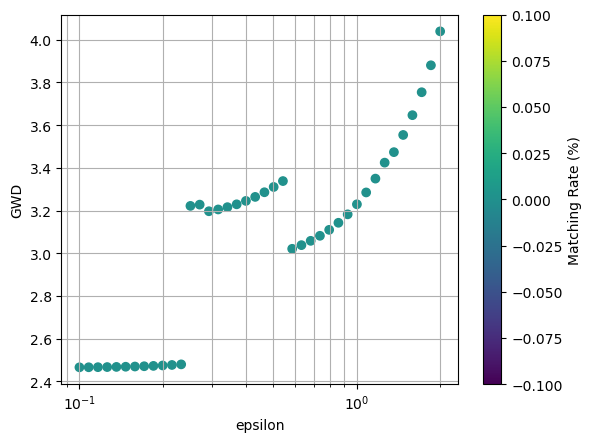

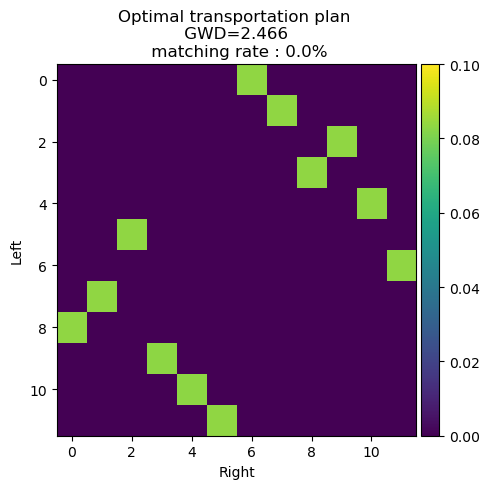

Minimum GWD for subject_02_subjec.csv and subject_06_subjec.csv: 2.4662876604347885 at epsilon 0.1 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_07_subjec.csv


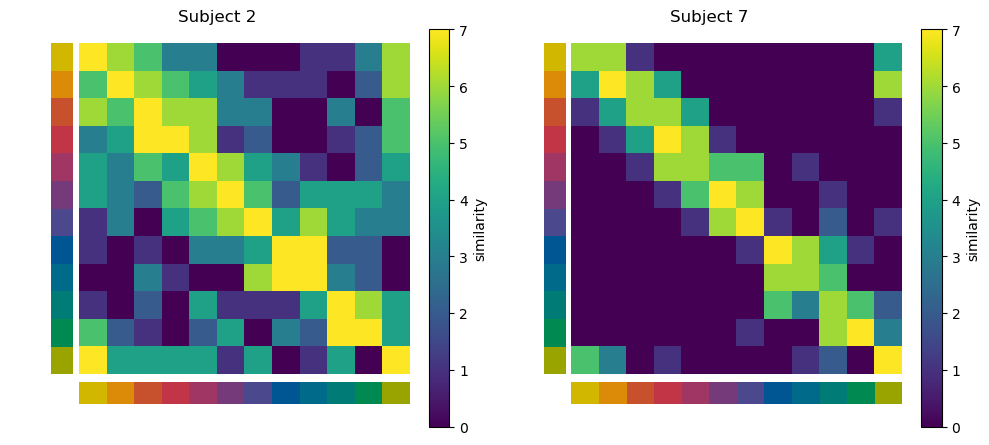

RSA correlation coefficient between subject_02_subjec.csv and subject_07_subjec.csv: 0.6931465027030782


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


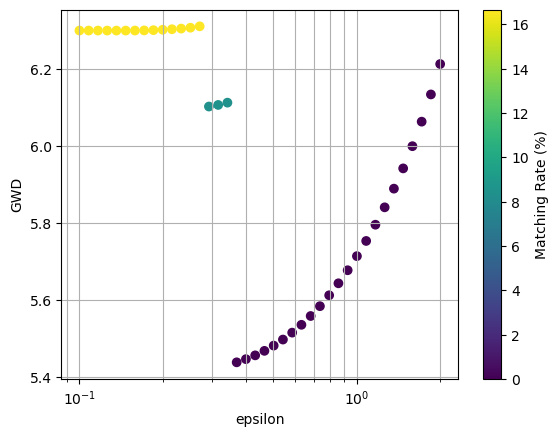

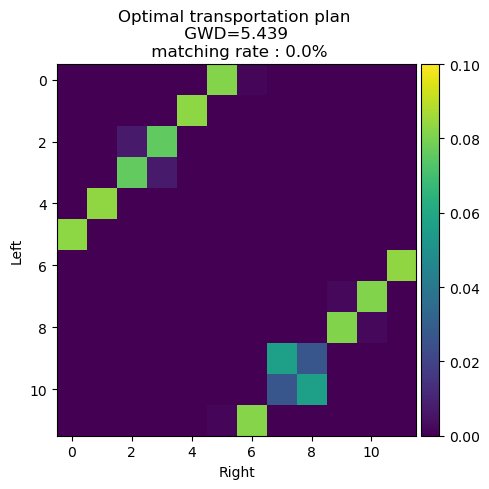

Minimum GWD for subject_02_subjec.csv and subject_07_subjec.csv: 5.438914721205288 at epsilon 0.3690758589290662 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_08_subjec.csv


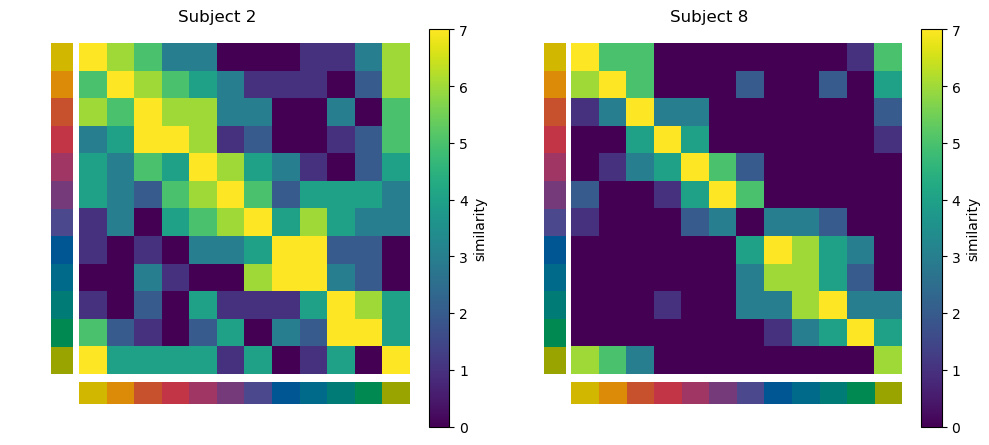

RSA correlation coefficient between subject_02_subjec.csv and subject_08_subjec.csv: 0.6793107437069743


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


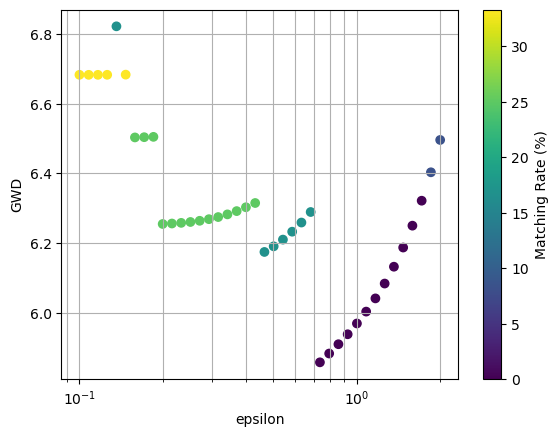

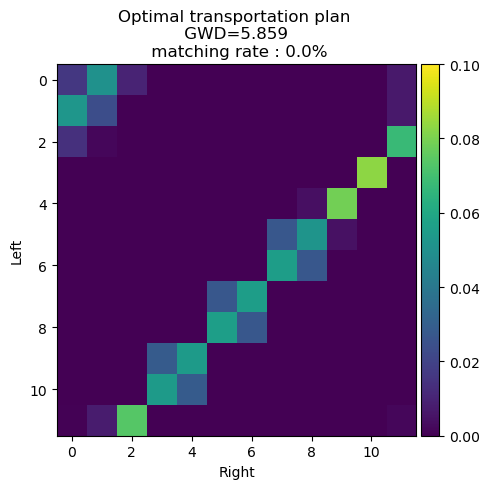

Minimum GWD for subject_02_subjec.csv and subject_08_subjec.csv: 5.85878503590859 at epsilon 0.7368062997280774 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_09_subjec.csv


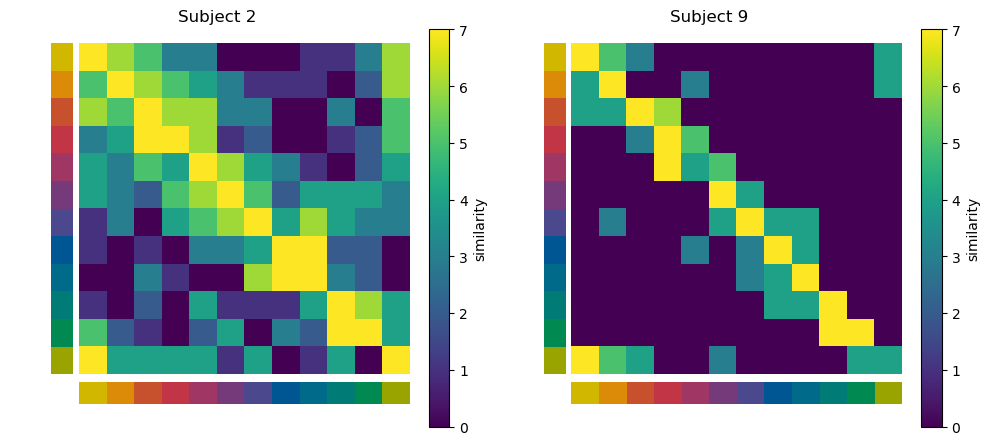

RSA correlation coefficient between subject_02_subjec.csv and subject_09_subjec.csv: 0.6131652953147007


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


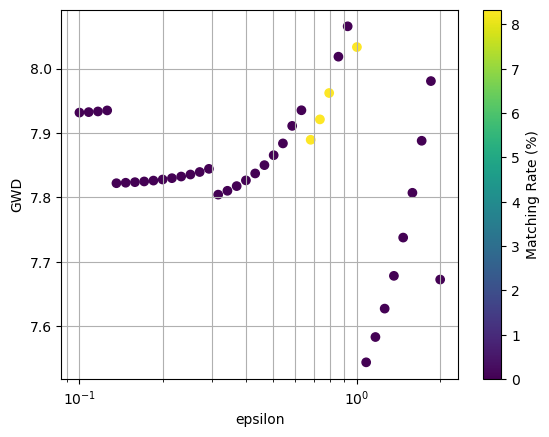

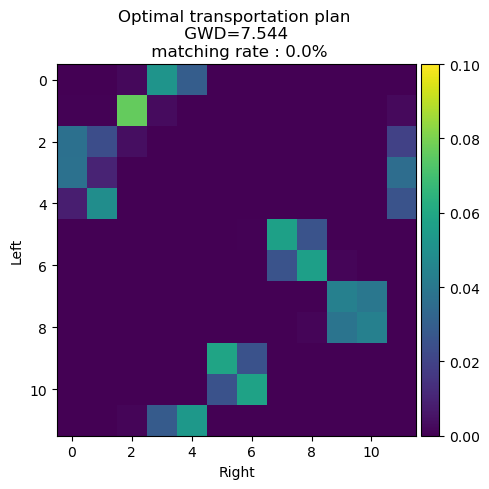

Minimum GWD for subject_02_subjec.csv and subject_09_subjec.csv: 7.5437235970576495 at epsilon 1.0818126309390206 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_10_subjec.csv


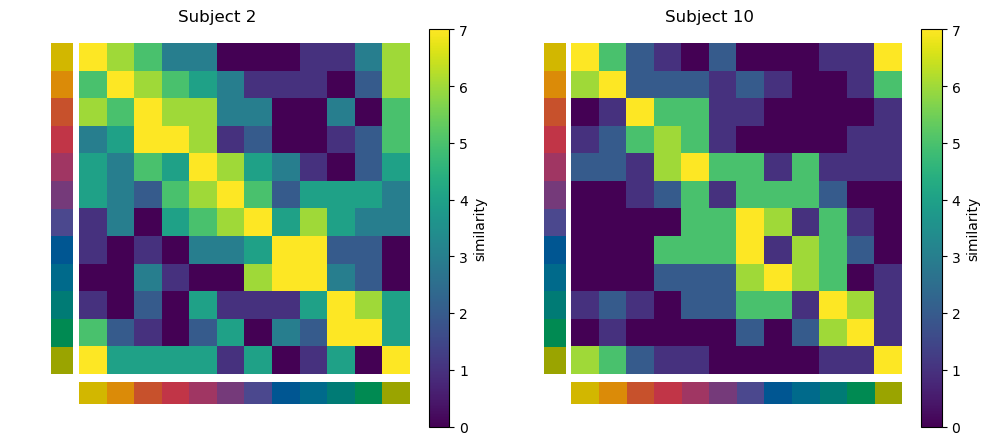

RSA correlation coefficient between subject_02_subjec.csv and subject_10_subjec.csv: 0.611062592098351


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


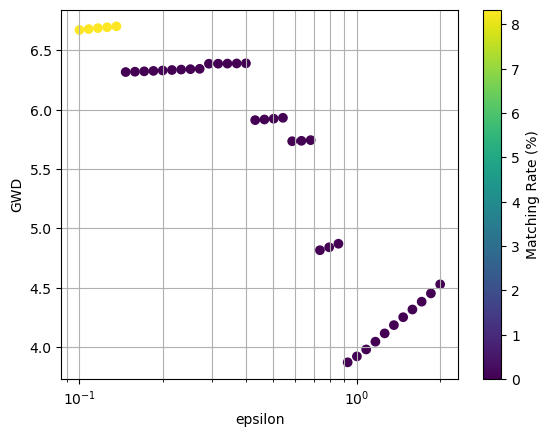

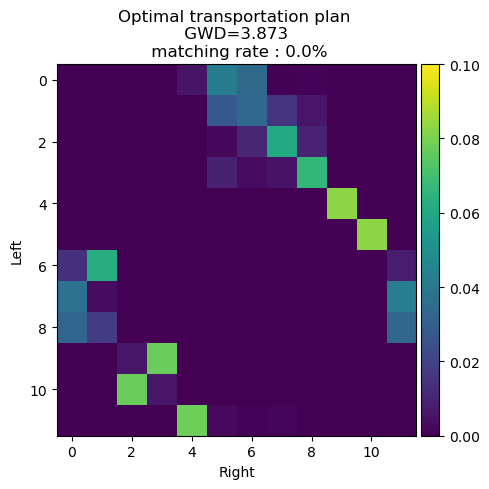

Minimum GWD for subject_02_subjec.csv and subject_10_subjec.csv: 3.873094377087971 at epsilon 0.9277534133867849 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_11_subjec.csv


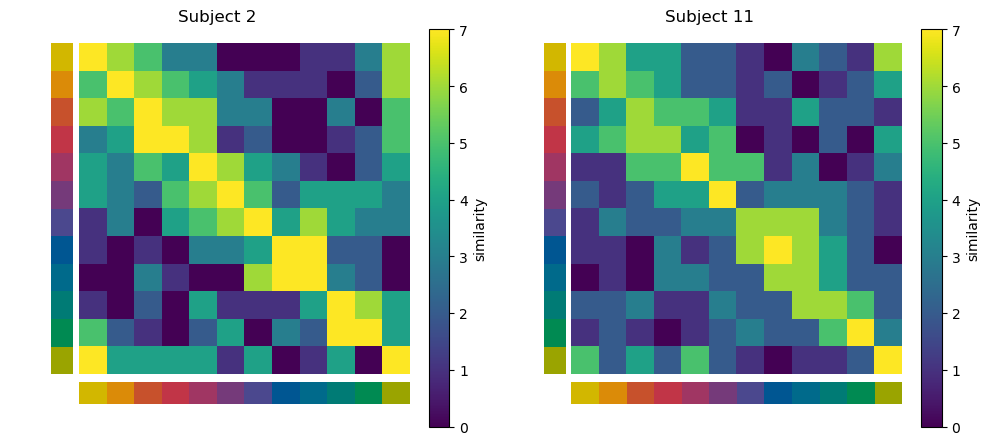

RSA correlation coefficient between subject_02_subjec.csv and subject_11_subjec.csv: 0.6791595257671027


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


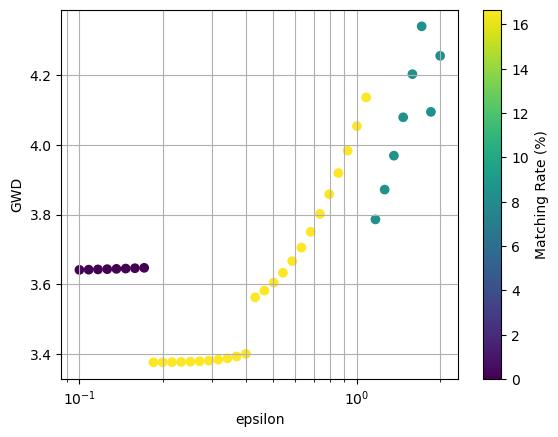

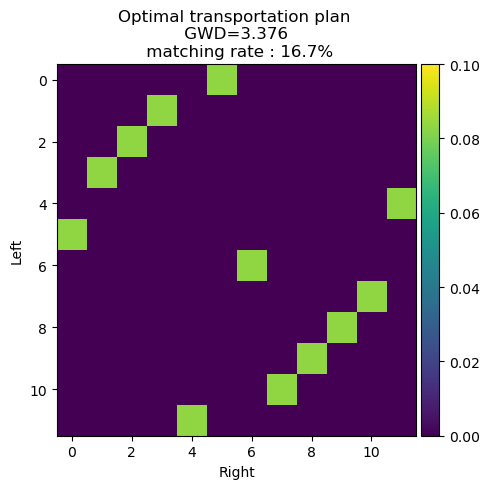

Minimum GWD for subject_02_subjec.csv and subject_11_subjec.csv: 3.3762292850563838 at epsilon 0.18487489818490913 with matching rate 16.666666666666664
Processing pair: subject_02_subjec.csv and subject_12_subjec.csv


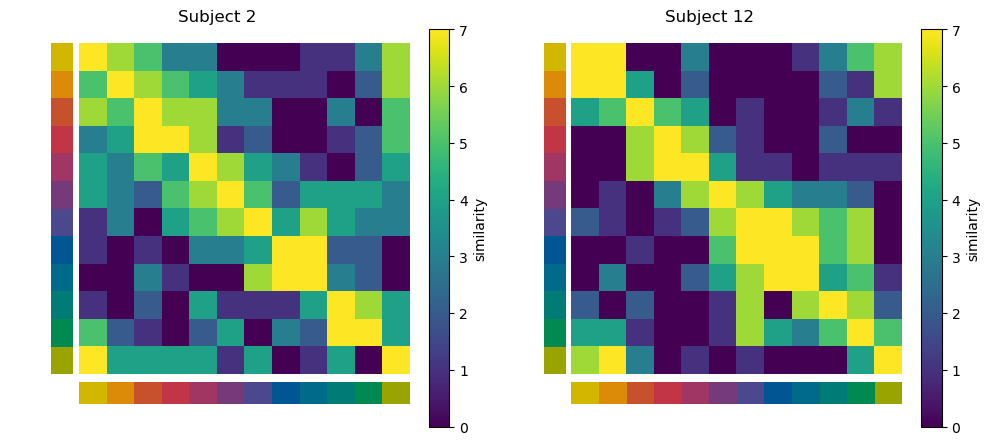

RSA correlation coefficient between subject_02_subjec.csv and subject_12_subjec.csv: 0.5865081589524352


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


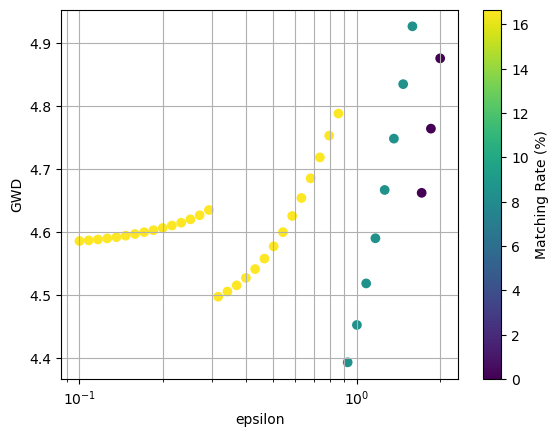

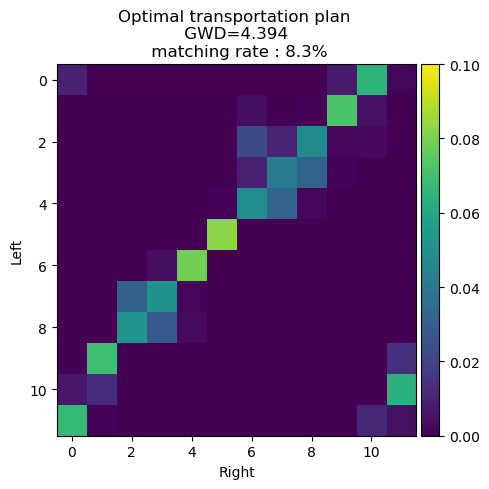

Minimum GWD for subject_02_subjec.csv and subject_12_subjec.csv: 4.393575806501364 at epsilon 0.9277534133867849 with matching rate 8.333333333333332
Processing pair: subject_02_subjec.csv and subject_13_subjec.csv


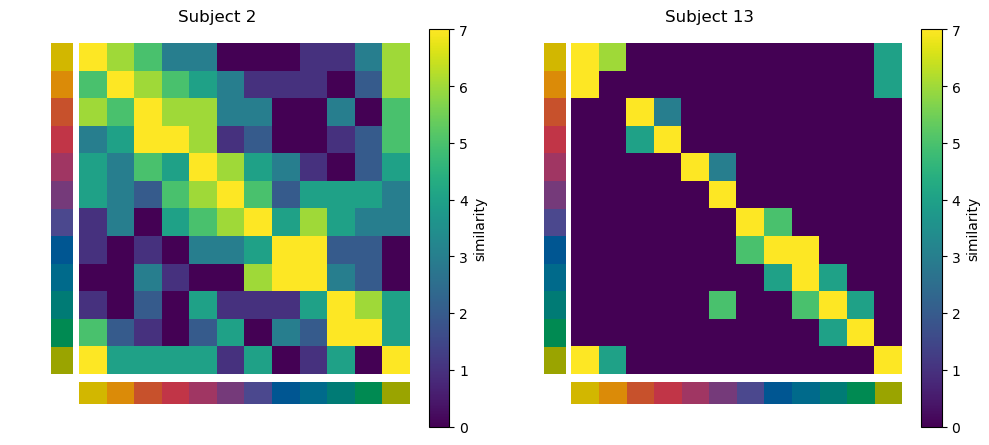

RSA correlation coefficient between subject_02_subjec.csv and subject_13_subjec.csv: 0.49818705264578417


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


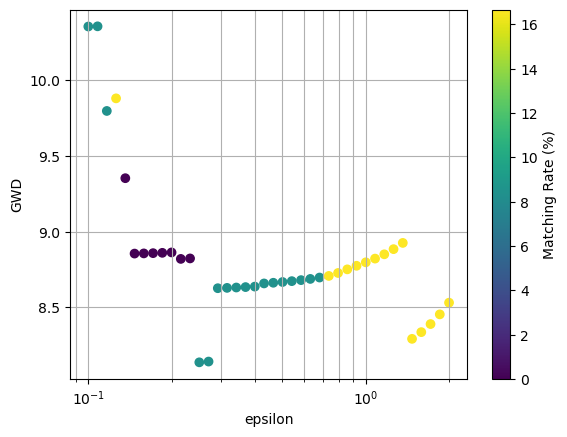

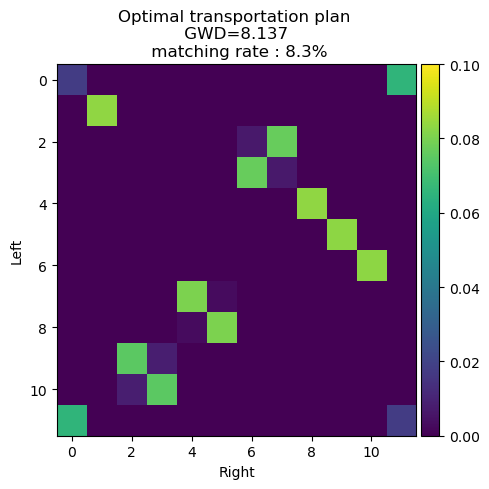

Minimum GWD for subject_02_subjec.csv and subject_13_subjec.csv: 8.137049349234248 at epsilon 0.25137201226837563 with matching rate 8.333333333333332
Processing pair: subject_02_subjec.csv and subject_14_subjec.csv


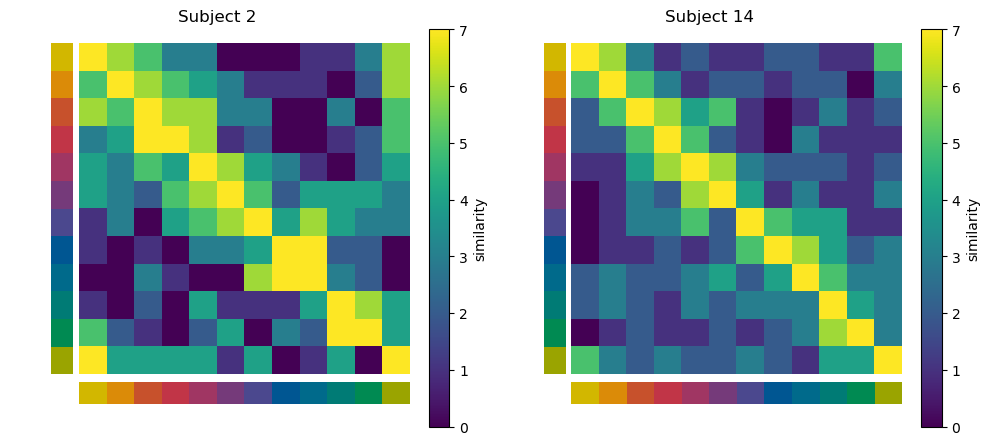

RSA correlation coefficient between subject_02_subjec.csv and subject_14_subjec.csv: 0.6322821126610356


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


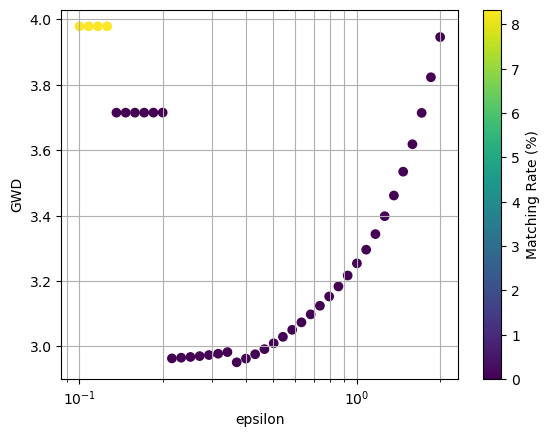

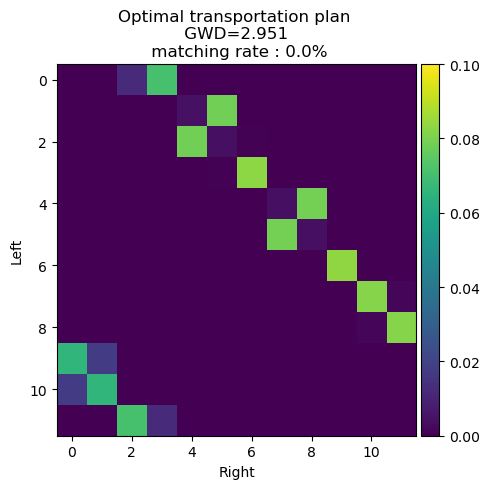

Minimum GWD for subject_02_subjec.csv and subject_14_subjec.csv: 2.951043048191034 at epsilon 0.3690758589290662 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_15_subjec.csv


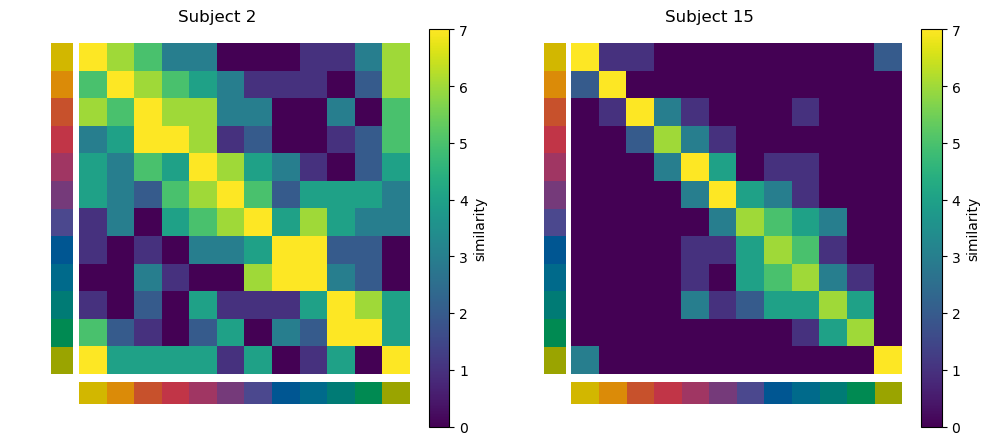

RSA correlation coefficient between subject_02_subjec.csv and subject_15_subjec.csv: 0.5087137627346949


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


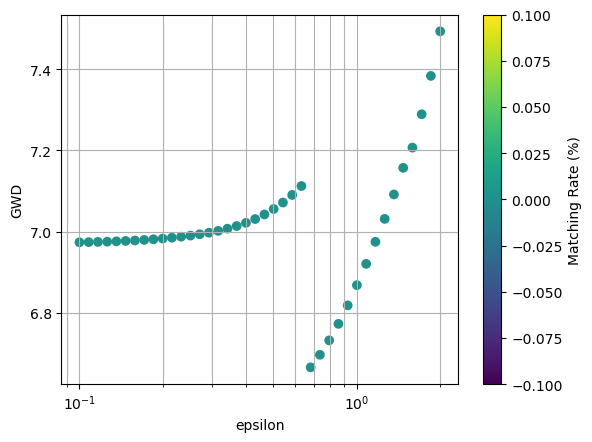

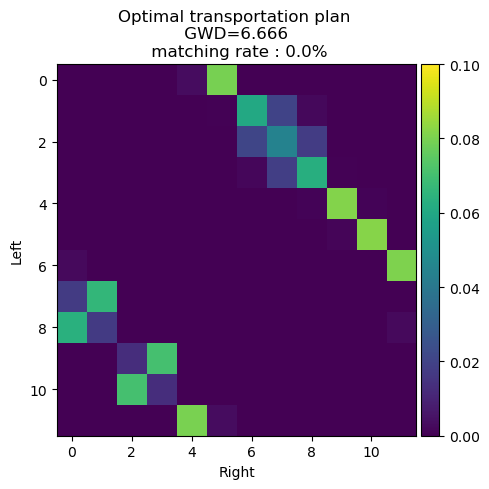

Minimum GWD for subject_02_subjec.csv and subject_15_subjec.csv: 6.665535885152691 at epsilon 0.6823286184201898 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_16_subjec.csv


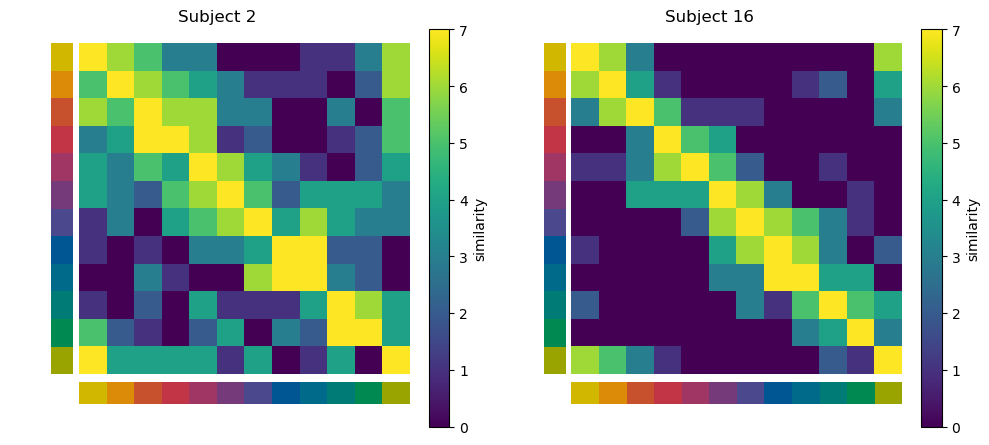

RSA correlation coefficient between subject_02_subjec.csv and subject_16_subjec.csv: 0.6369576178059734


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


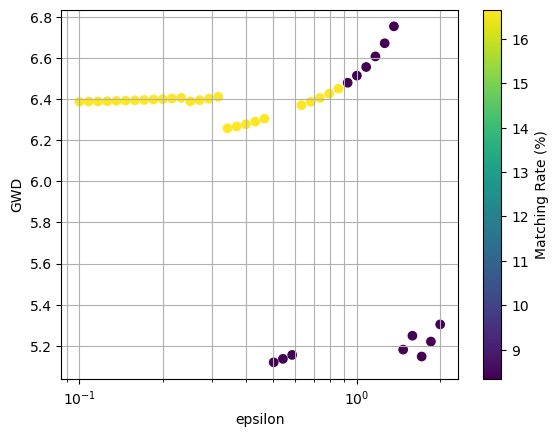

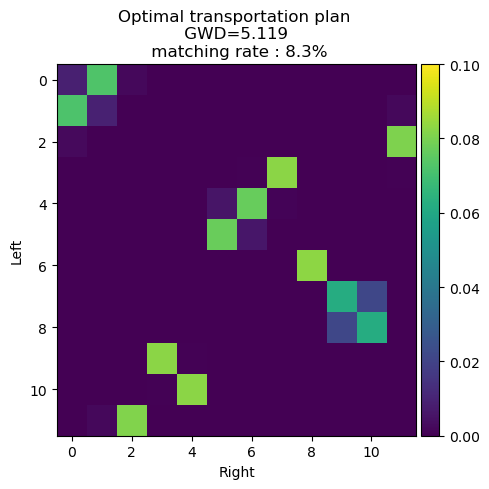

Minimum GWD for subject_02_subjec.csv and subject_16_subjec.csv: 5.119462087933476 at epsilon 0.5018276804993071 with matching rate 8.333333333333332
Processing pair: subject_02_subjec.csv and subject_17_subjec.csv


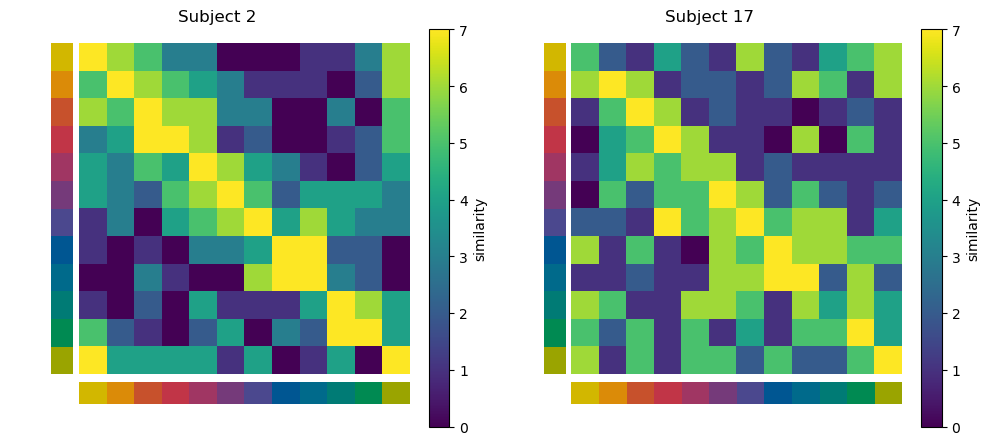

RSA correlation coefficient between subject_02_subjec.csv and subject_17_subjec.csv: 0.32193297868030524


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


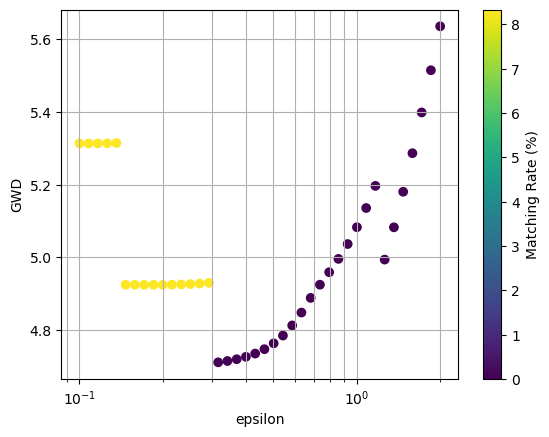

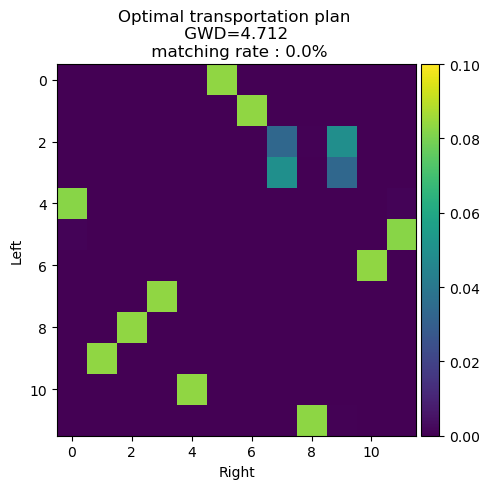

Minimum GWD for subject_02_subjec.csv and subject_17_subjec.csv: 4.711748411412616 at epsilon 0.31651635239541004 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_18_subjec.csv


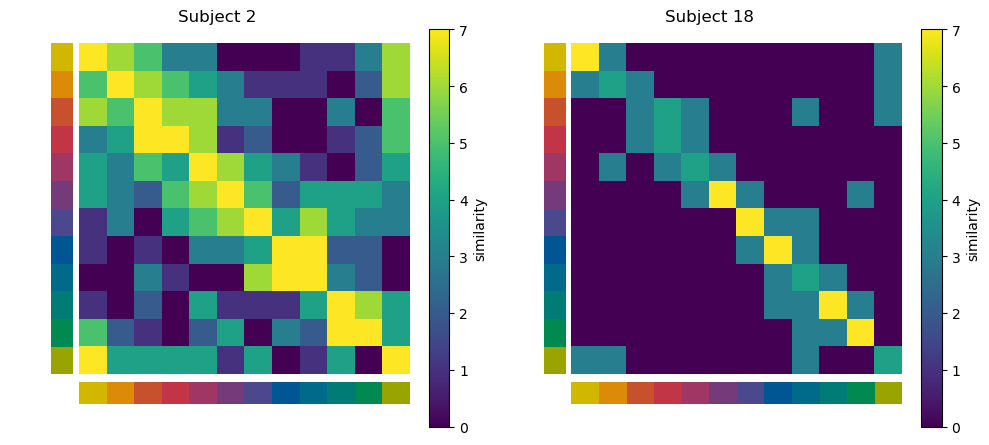

RSA correlation coefficient between subject_02_subjec.csv and subject_18_subjec.csv: 0.6463682408209572


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


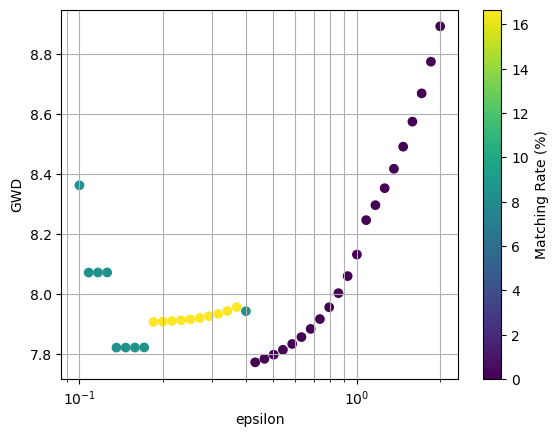

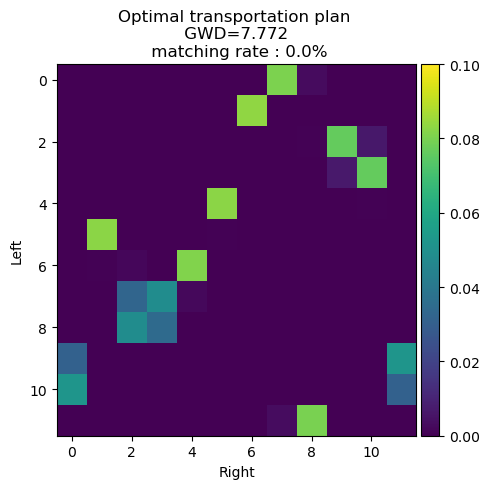

Minimum GWD for subject_02_subjec.csv and subject_18_subjec.csv: 7.771563391745724 at epsilon 0.43036319802541523 with matching rate 0.0
Processing pair: subject_02_subjec.csv and subject_19_subjec.csv


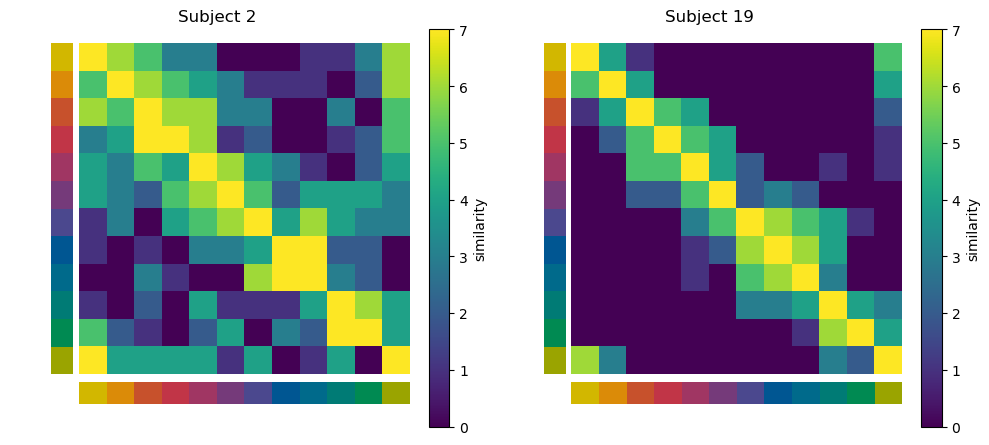

RSA correlation coefficient between subject_02_subjec.csv and subject_19_subjec.csv: 0.6835500564689742


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


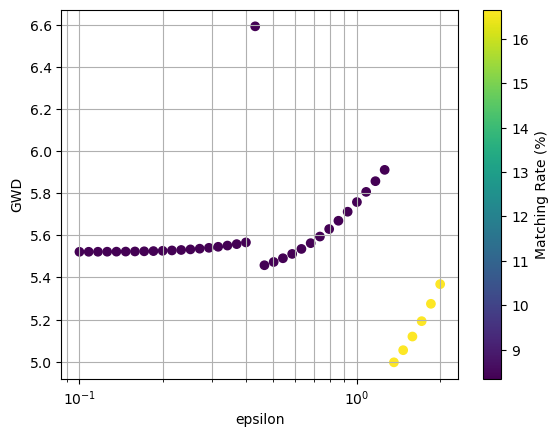

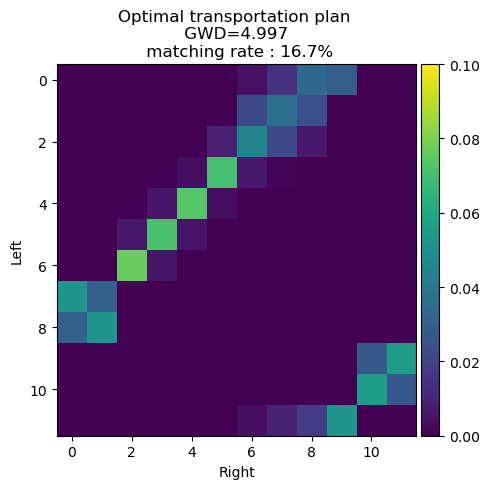

Minimum GWD for subject_02_subjec.csv and subject_19_subjec.csv: 4.996989525192793 at epsilon 1.3621698964422795 with matching rate 16.666666666666664
Processing pair: subject_03_subjec.csv and subject_04_subjec.csv


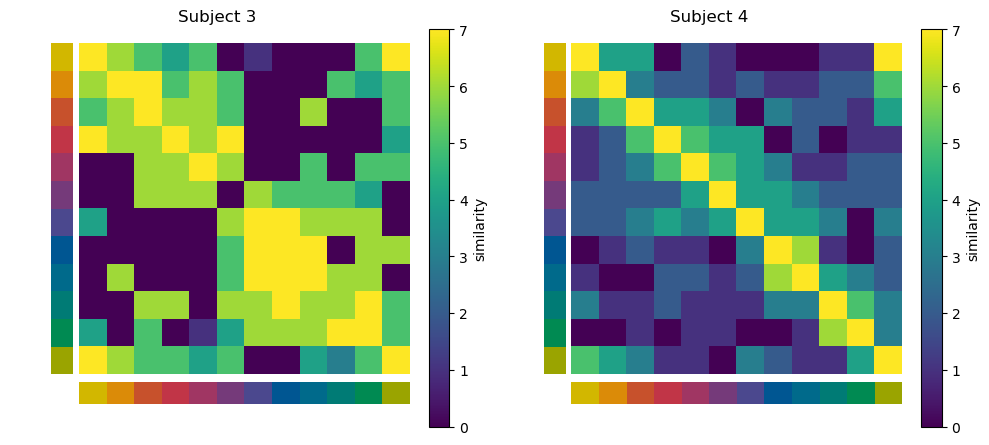

RSA correlation coefficient between subject_03_subjec.csv and subject_04_subjec.csv: 0.5264676339606729


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


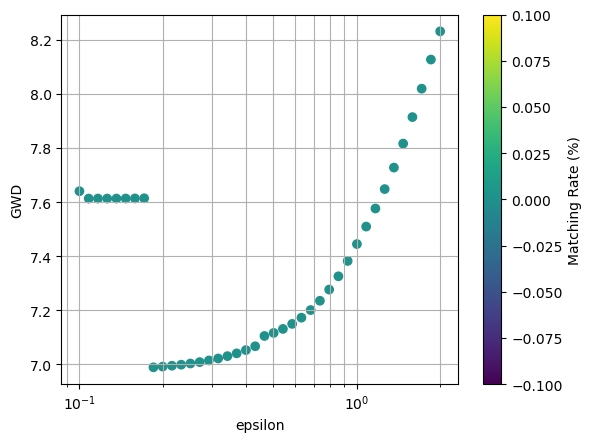

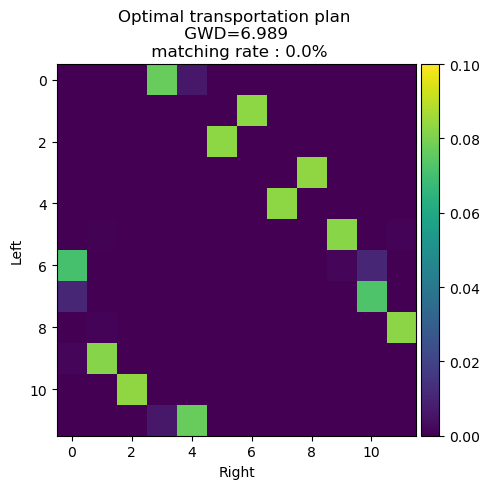

Minimum GWD for subject_03_subjec.csv and subject_04_subjec.csv: 6.9890949568127505 at epsilon 0.18487489818490913 with matching rate 0.0
Processing pair: subject_03_subjec.csv and subject_05_subjec.csv


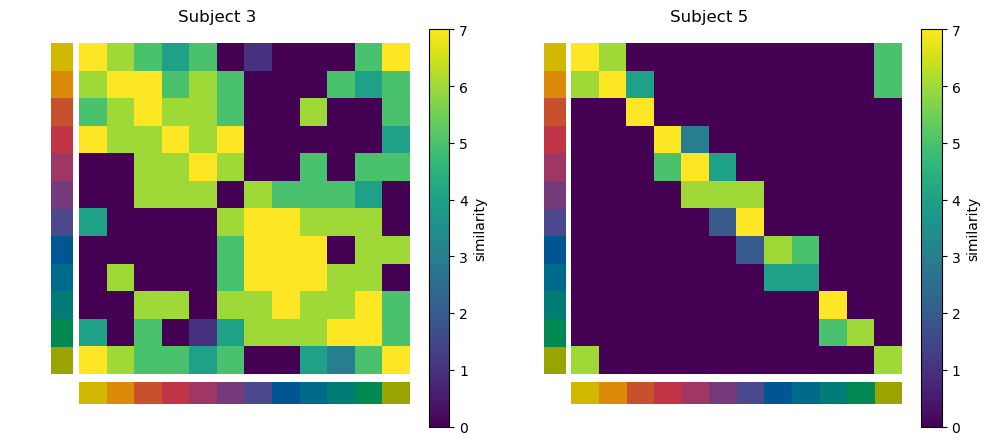

RSA correlation coefficient between subject_03_subjec.csv and subject_05_subjec.csv: 0.3568814975098542


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


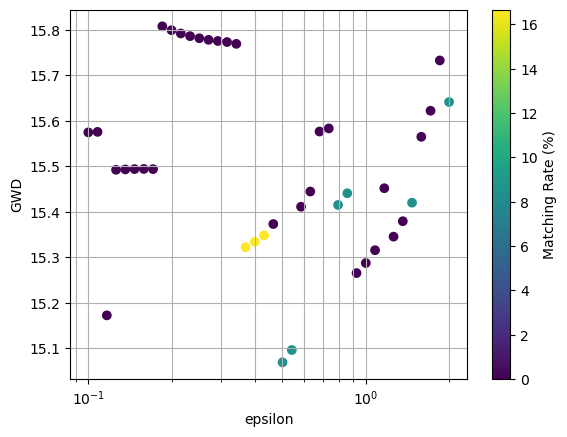

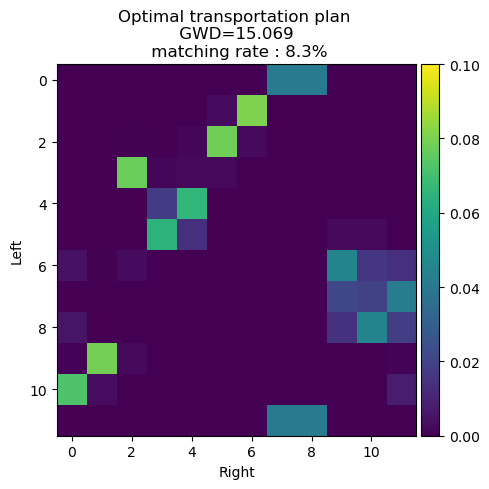

Minimum GWD for subject_03_subjec.csv and subject_05_subjec.csv: 15.06914325413964 at epsilon 0.5018276804993071 with matching rate 8.333333333333332
Processing pair: subject_03_subjec.csv and subject_06_subjec.csv


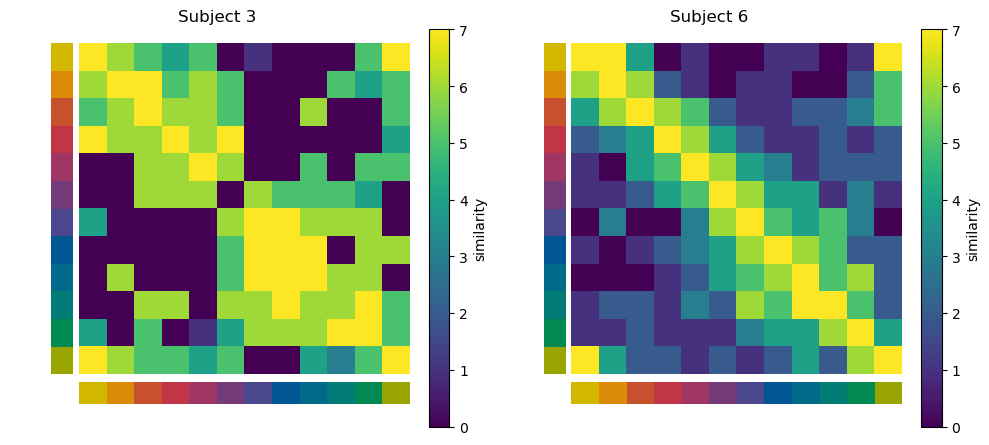

RSA correlation coefficient between subject_03_subjec.csv and subject_06_subjec.csv: 0.5767257248742699


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


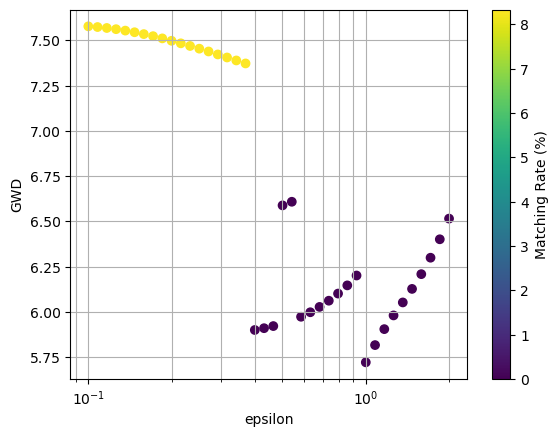

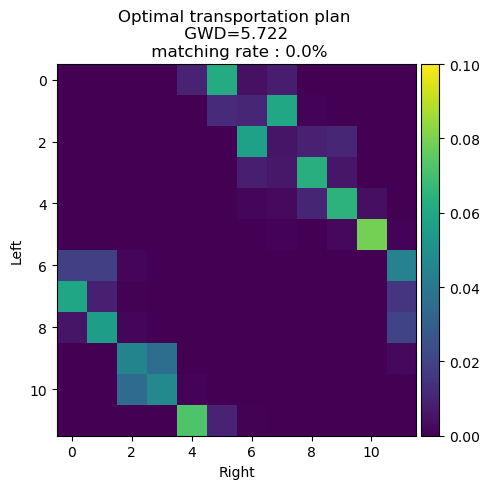

Minimum GWD for subject_03_subjec.csv and subject_06_subjec.csv: 5.7221757728805756 at epsilon 1.0018260133369539 with matching rate 0.0
Processing pair: subject_03_subjec.csv and subject_07_subjec.csv


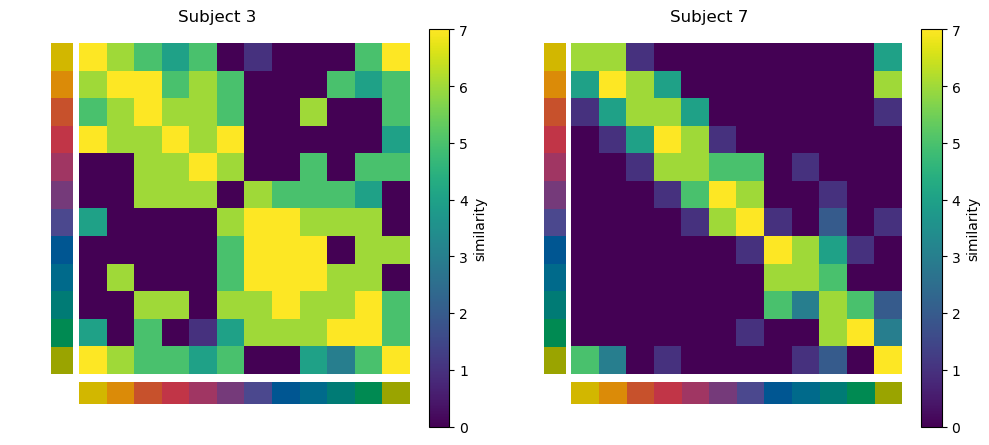

RSA correlation coefficient between subject_03_subjec.csv and subject_07_subjec.csv: 0.4400928018295018


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


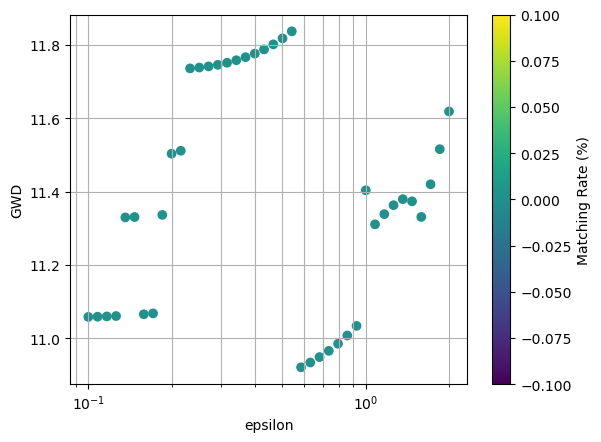

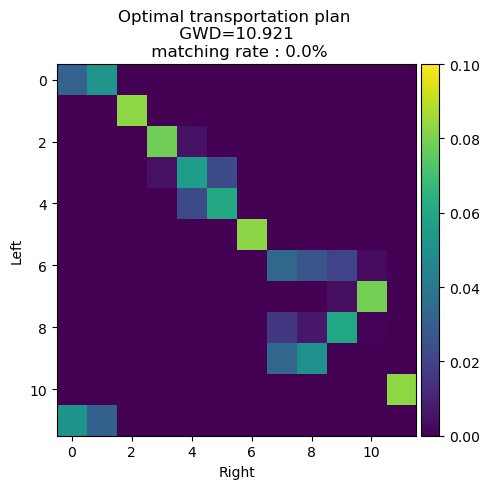

Minimum GWD for subject_03_subjec.csv and subject_07_subjec.csv: 10.921081577382548 at epsilon 0.5851592842296025 with matching rate 0.0
Processing pair: subject_03_subjec.csv and subject_08_subjec.csv


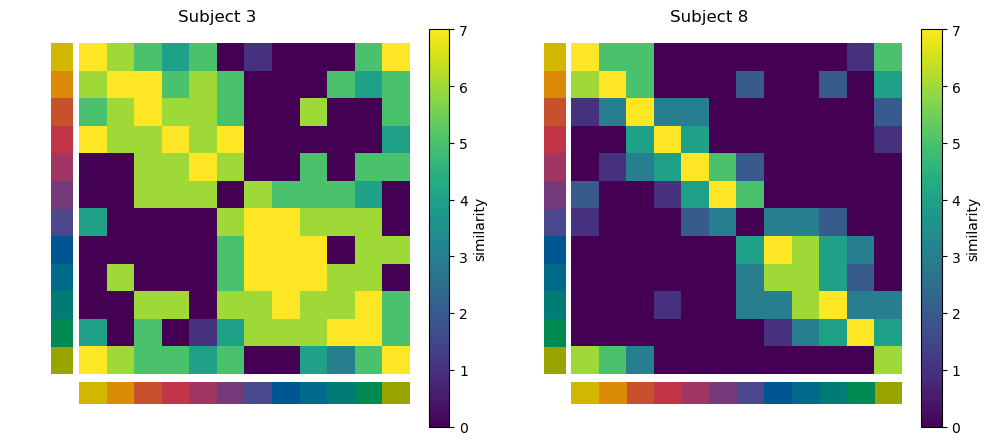

RSA correlation coefficient between subject_03_subjec.csv and subject_08_subjec.csv: 0.5176219012464089


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


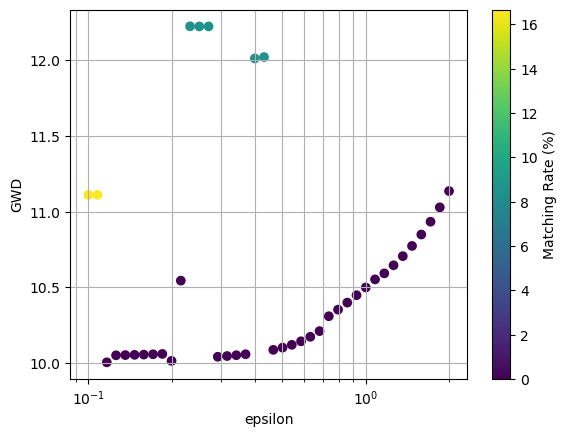

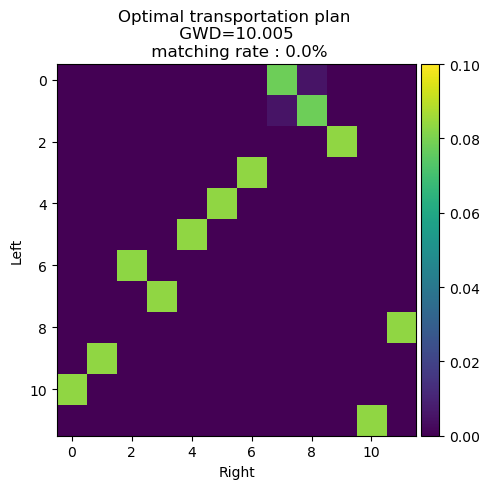

Minimum GWD for subject_03_subjec.csv and subject_08_subjec.csv: 10.00489231046228 at epsilon 0.1166056212059451 with matching rate 0.0
Processing pair: subject_03_subjec.csv and subject_09_subjec.csv


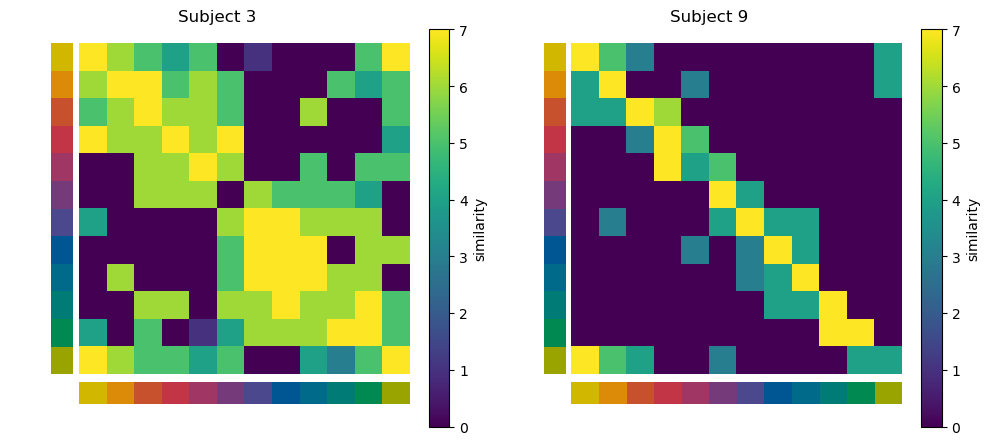

RSA correlation coefficient between subject_03_subjec.csv and subject_09_subjec.csv: 0.42978249645842725


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


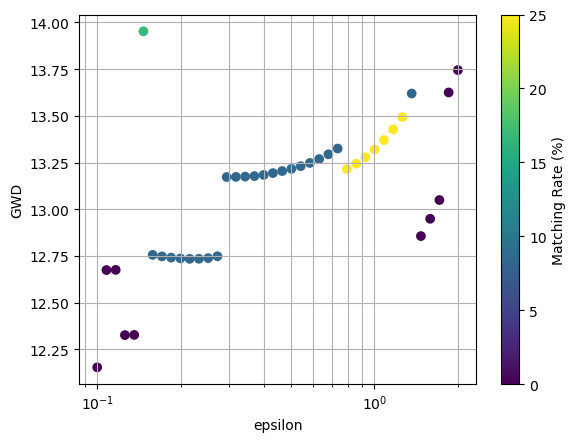

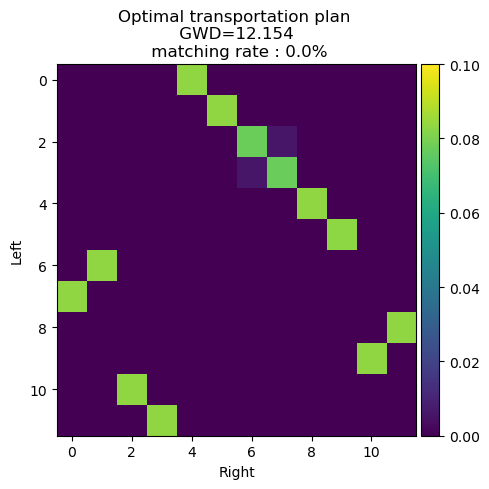

Minimum GWD for subject_03_subjec.csv and subject_09_subjec.csv: 12.154133086563096 at epsilon 0.1 with matching rate 0.0
Processing pair: subject_03_subjec.csv and subject_10_subjec.csv


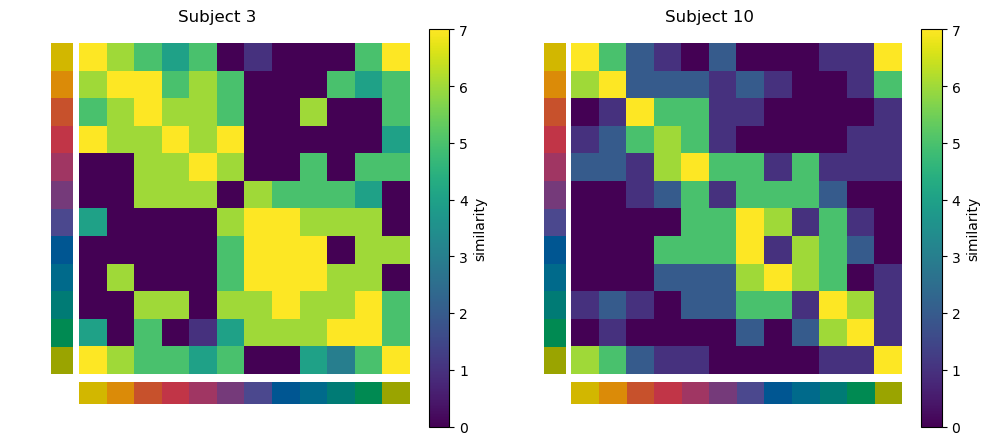

RSA correlation coefficient between subject_03_subjec.csv and subject_10_subjec.csv: 0.4862323272749296


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


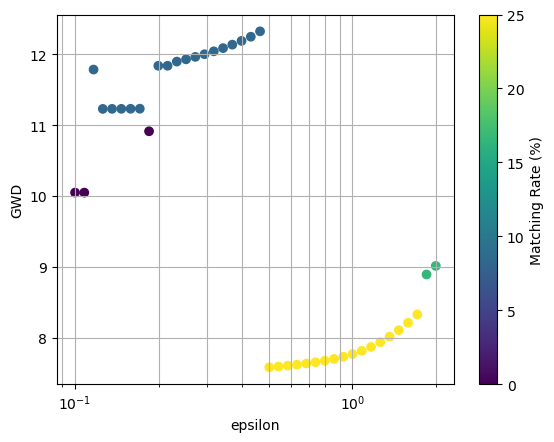

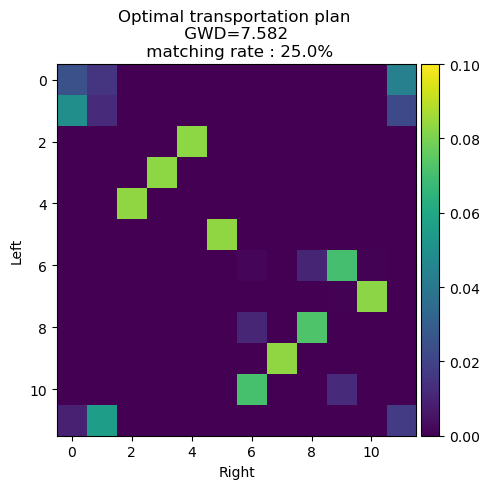

Minimum GWD for subject_03_subjec.csv and subject_10_subjec.csv: 7.5816474779268015 at epsilon 0.5018276804993071 with matching rate 25.0
Processing pair: subject_03_subjec.csv and subject_11_subjec.csv


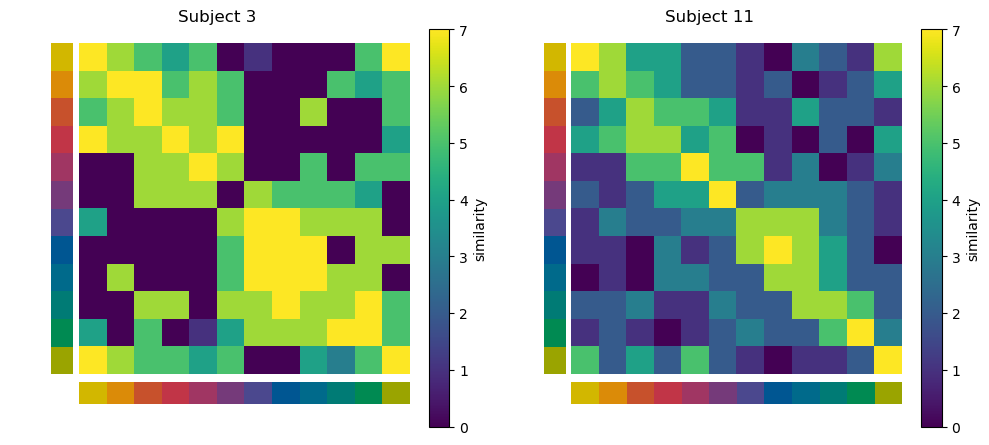

RSA correlation coefficient between subject_03_subjec.csv and subject_11_subjec.csv: 0.6046677143485231


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


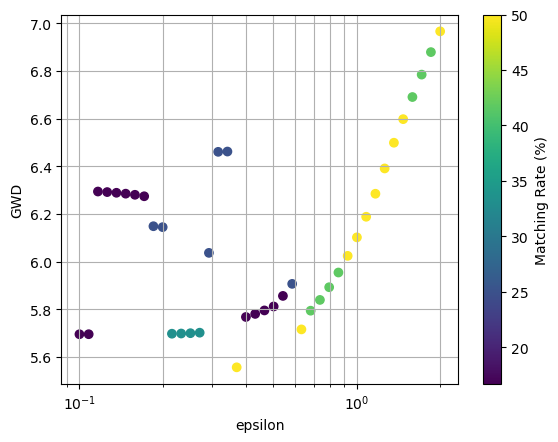

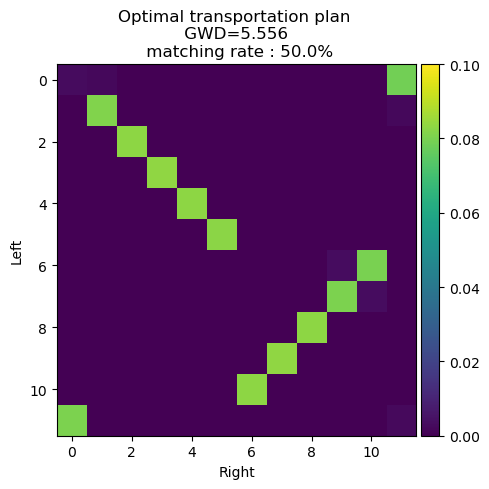

Minimum GWD for subject_03_subjec.csv and subject_11_subjec.csv: 5.556487348826587 at epsilon 0.3690758589290662 with matching rate 50.0
Processing pair: subject_03_subjec.csv and subject_12_subjec.csv


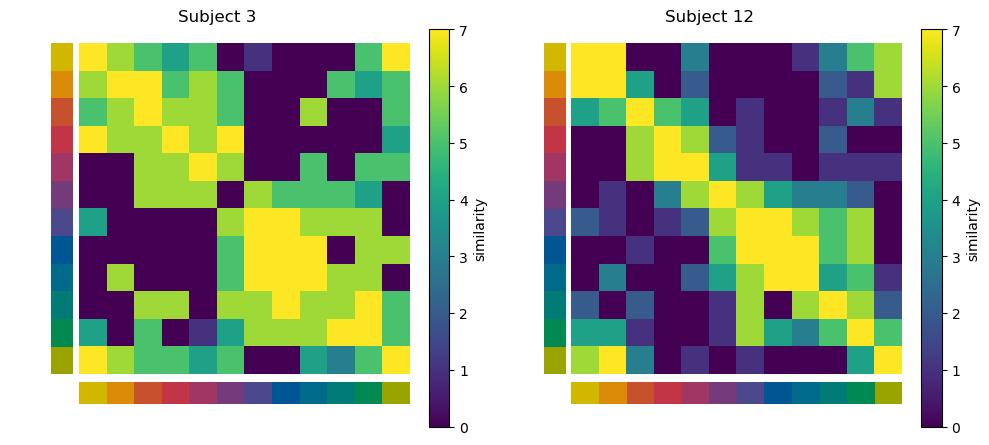

RSA correlation coefficient between subject_03_subjec.csv and subject_12_subjec.csv: 0.5905858140040636


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


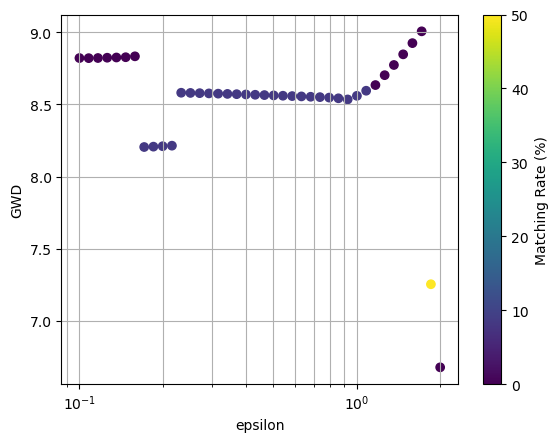

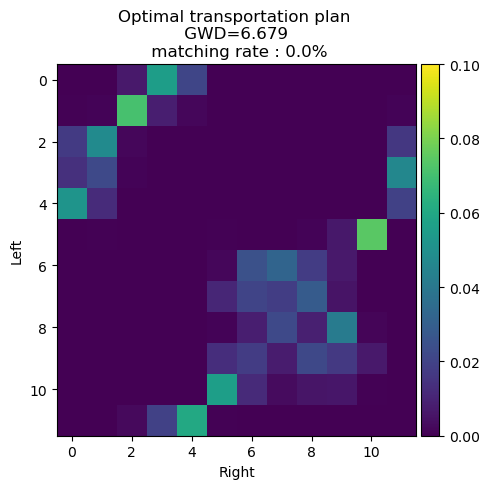

Minimum GWD for subject_03_subjec.csv and subject_12_subjec.csv: 6.678897657177012 at epsilon 2.0 with matching rate 0.0
Processing pair: subject_03_subjec.csv and subject_13_subjec.csv


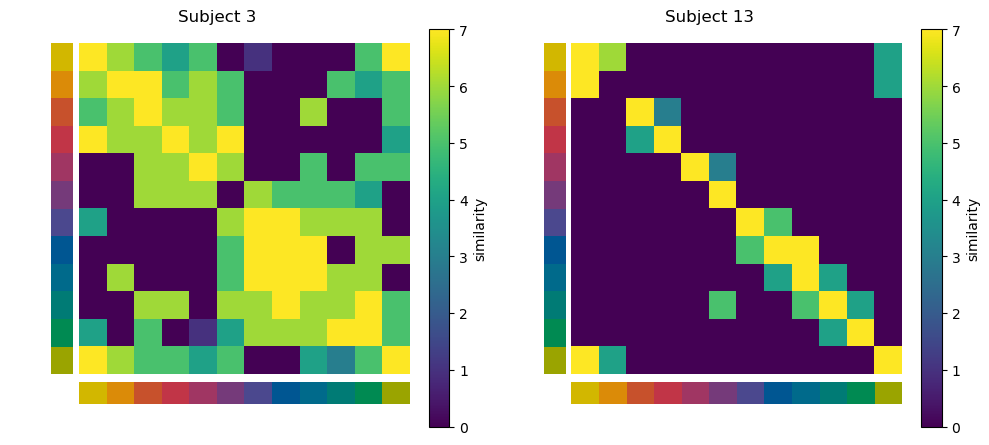

RSA correlation coefficient between subject_03_subjec.csv and subject_13_subjec.csv: 0.3964903524890753


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


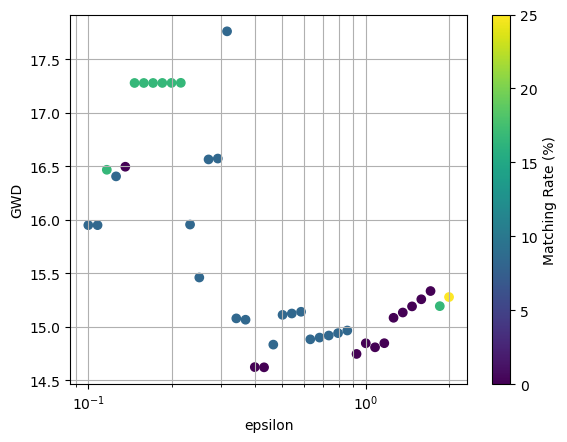

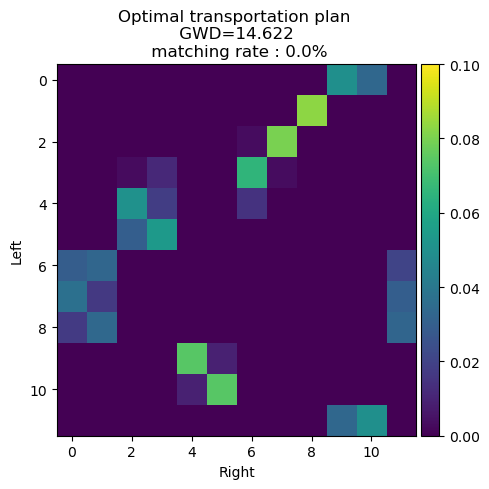

Minimum GWD for subject_03_subjec.csv and subject_13_subjec.csv: 14.621819515480937 at epsilon 0.43036319802541523 with matching rate 0.0
Processing pair: subject_03_subjec.csv and subject_14_subjec.csv


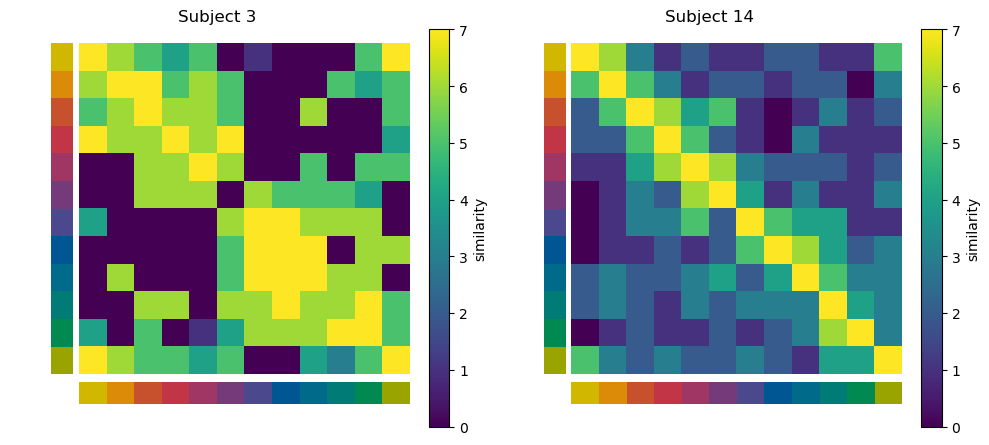

RSA correlation coefficient between subject_03_subjec.csv and subject_14_subjec.csv: 0.4891058909902917


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


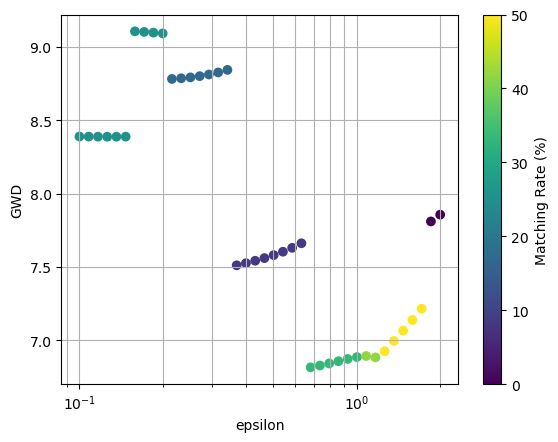

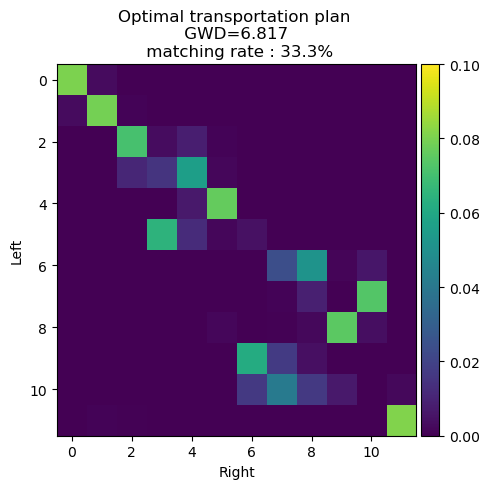

Minimum GWD for subject_03_subjec.csv and subject_14_subjec.csv: 6.817221875176983 at epsilon 0.6823286184201898 with matching rate 33.33333333333333
Processing pair: subject_03_subjec.csv and subject_15_subjec.csv


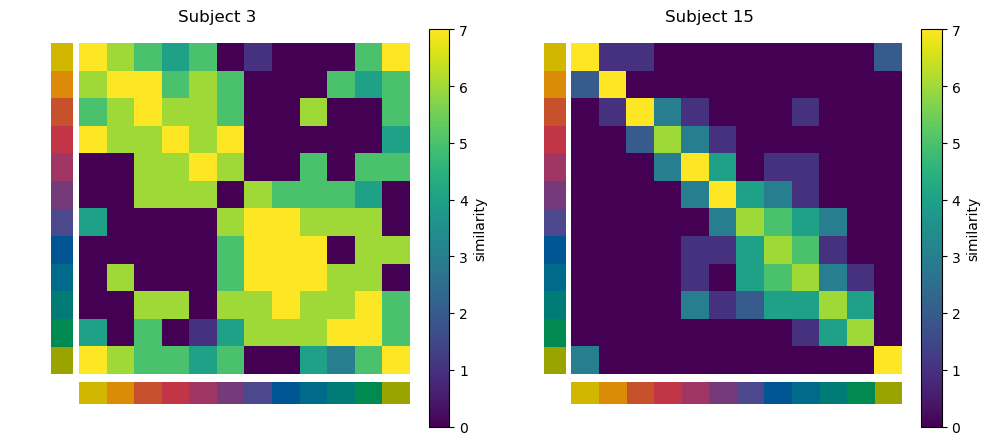

RSA correlation coefficient between subject_03_subjec.csv and subject_15_subjec.csv: 0.5083560705207053


/Users/kanamatsuyanagi/anaconda3/envs/GWOT/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


KeyboardInterrupt: 

In [3]:
import os
import numpy as np
import pandas as pd
import utilityFunctions
from itertools import combinations

# Configuration
folder_path = 'raw_data/202411_data_1'
response_type = 'similarity'
n_eps = 40  # Number of epsilon values tried
eps_range = [0.1, 2]  # Range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps)  # Epsilon values

# Define unique colors
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)

# Function to load and process a CSV file into a matrix
def load_csv_to_matrix(file_path, response_type, colour_index, matrix_size):
    df = pd.read_csv(file_path)
    df = df[(df['practice_trial'] != 1) & (df['response_type'] == response_type)]

    colour1 = df['colour1']
    colour2 = df['colour2']
    target_preference = df['response']

    matrix = np.zeros((matrix_size, matrix_size))
    for c1, c2, tp in zip(colour1, colour2, target_preference):
        I = colour_index[c1]
        j = colour_index[c2]
        matrix[I, j] = tp

    return matrix.astype(int)

# Function to sort files, rename them, and assign subject IDs
def sort_and_rename_files(folder_path):
    csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    subject_ids = {}

    for idx, file in enumerate(csv_files):
        prefix = file[:6]  # Extract the first 6 characters from the original file name
        new_name = f"subject_{idx + 1:02d}_{prefix}.csv"
        old_path = os.path.join(folder_path, file)
        new_path = os.path.join(folder_path, new_name)
        os.rename(old_path, new_path)
        subject_ids[new_name] = idx + 1

    return list(subject_ids.keys()), subject_ids

# Sort and rename files, then assign subject IDs
csv_files, subject_ids = sort_and_rename_files(folder_path)

# Generate all possible pairs of files
file_pairs = list(combinations(csv_files, 2))

# Initialize lists to store results
file1_list = []
file2_list = []
subject_id1_list = []
subject_id2_list = []
epsilon_range_list = []
gwds_list = []
ot_plans_list = []
matching_rates_list = []
RSA_correlations_list = []
min_gwds_list = []
best_epsilons_list = []
best_matching_rates_list = []

# Process each pair
for file1, file2 in file_pairs:
    print(f"Processing pair: {file1} and {file2}")

    # Load matrices
    matrix_1 = load_csv_to_matrix(os.path.join(folder_path, file1), response_type, colour_index, matrix_size)
    matrix_2 = load_csv_to_matrix(os.path.join(folder_path, file2), response_type, colour_index, matrix_size)

    # Extract subject IDs for titles
    subject_id1 = f"Subject {subject_ids[file1]}"
    subject_id2 = f"Subject {subject_ids[file2]}"

    # Show heatmaps
    utilityFunctions.show_heatmaps(0, 7, matrices=[matrix_1, matrix_2], titles=[subject_id1, subject_id2], cbar_label="similarity", color_labels=unique_colours)

    # Calculate RSA correlation
    RSA_corr = utilityFunctions.RSA(matrix_1, matrix_2)
    print(f'RSA correlation coefficient between {file1} and {file2}: {RSA_corr}')

    # Perform GWOT
    OT_plan, gwds, matching_rates = utilityFunctions.GWD_and_plot(matrix_1, matrix_2, epsilons)
    min_gwd_index = np.argmin(gwds)
    min_gwd = gwds[min_gwd_index]
    best_epsilon = epsilons[min_gwd_index]
    best_matching_rate = matching_rates[min_gwd_index]

    print(f"Minimum GWD for {file1} and {file2}: {min_gwd} at epsilon {best_epsilon} with matching rate {best_matching_rate}")

    # Append results to lists
    file1_list.append(file1)
    file2_list.append(file2)
    subject_id1_list.append(subject_id1)
    subject_id2_list.append(subject_id2)
    epsilon_range_list.append(eps_range)
    gwds_list.append(gwds)
    ot_plans_list.append(OT_plan)
    matching_rates_list.append(matching_rates)
    RSA_correlations_list.append(RSA_corr)
    min_gwds_list.append(min_gwd)
    best_epsilons_list.append(best_epsilon)
    best_matching_rates_list.append(best_matching_rate)

# Convert lists to numpy arrays
file1_array = np.array(file1_list, dtype=object)
file2_array = np.array(file2_list, dtype=object)
subject_id1_array = np.array(subject_id1_list, dtype=object)
subject_id2_array = np.array(subject_id2_list, dtype=object)
epsilon_range_array = np.array(epsilon_range_list, dtype=object)
gwds_array = np.array(gwds_list, dtype=object)
ot_plans_array = np.array(ot_plans_list, dtype=object)
matching_rates_array = np.array(matching_rates_list, dtype=object)
RSA_correlations_array = np.array(RSA_correlations_list, dtype=object)
min_gwds_array = np.array(min_gwds_list, dtype=float)
best_epsilons_array = np.array(best_epsilons_list, dtype=float)
best_matching_rates_array = np.array(best_matching_rates_list, dtype=float)

# Combine all arrays into a single numpy array
all_results_array = np.array([
    file1_array,
    file2_array,
    subject_id1_array,
    subject_id2_array,
    epsilon_range_array,
    gwds_array,
    ot_plans_array,
    matching_rates_array,
    RSA_correlations_array,
    min_gwds_array,
    best_epsilons_array,
    best_matching_rates_array
], dtype=object)

# Save the combined array to a .npz file
output_file = os.path.join(folder_path, 'pairwise_results_extended.npz')
np.savez(output_file,
         file1=file1_array,
         file2=file2_array,
         subject_id1=subject_id1_array,
         subject_id2=subject_id2_array,
         epsilon_range=epsilon_range_array,
         gwds=gwds_array,
         ot_plans=ot_plans_array,
         matching_rates=matching_rates_array,
         RSA_correlations=RSA_correlations_array,
         min_gwds=min_gwds_array,
         best_epsilons=best_epsilons_array,
         best_matching_rates=best_matching_rates_array)

print(f"Results saved to {output_file}")
